In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")


def get_data(filter1: str, filter2: str):


    # Read the input data from the CSV file
    data = pd.read_csv('inputs.csv', parse_dates=['date']) # date,avg_efficiency,max_efficiency,open_price

    # keep only data after filter
    # data = data[data['date'] >= filter1]
    # data = data[data['date'] < filter2]

    # # create a dummy variable that is 0 before the filter1 and 1 after the filter1
    # data['dummy'] = (data['date'] >= filter1).astype(int)

    # time variable: (year-2011)*12+month
    data['time'] = (data['date'].dt.year - 2011) * 12 + data['date'].dt.month

    # Calculate the derivative of ln avg_efficiency and ln max_efficiency per day
    data['ln_avg_efficiency'] = np.log(data['avg_efficiency'])
    data['ln_max_efficiency'] = np.log(data['max_efficiency'])
    data['d_ln_avg_efficiency'] = data['ln_avg_efficiency'].diff()
    data['d_ln_max_efficiency'] = data['ln_max_efficiency'].diff()

    # Fill NaN values after computing differences
    data.fillna(method='bfill', inplace=True)

    # Create monthly averages
    monthly_data = data.resample('M', on='date').mean()

    # Create weekly averages
    weekly_data = data.resample('W', on='date').mean()

    # Keep daily data
    daily_data = data

    # Ensure no infinite values are present
    monthly_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    weekly_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    daily_data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill any remaining NaN values that might disrupt the model fitting
    monthly_data.ffill(inplace=True)
    weekly_data.ffill(inplace=True)
    daily_data.ffill(inplace=True)

    # Add squared max_efficiency derivative for model estimation
    monthly_data['d_ln_max_efficiency_squared'] = monthly_data['d_ln_max_efficiency'] ** 2
    weekly_data['d_ln_max_efficiency_squared'] = weekly_data['d_ln_max_efficiency'] ** 2
    daily_data['d_ln_max_efficiency_squared'] = daily_data['d_ln_max_efficiency'] ** 2

    # Add squared avg_efficiency derivative for model estimation
    monthly_data['d_ln_avg_efficiency_squared'] = monthly_data['d_ln_avg_efficiency'] ** 2
    weekly_data['d_ln_avg_efficiency_squared'] = weekly_data['d_ln_avg_efficiency'] ** 2
    daily_data['d_ln_avg_efficiency_squared'] = daily_data['d_ln_avg_efficiency'] ** 2

    # Differencing the series to make it stationary
    monthly_data['open_price_diff'] = monthly_data['open_price'].diff().fillna(method='bfill')
    weekly_data['open_price_diff'] = weekly_data['open_price'].diff().fillna(method='bfill')
    daily_data['open_price_diff'] = daily_data['open_price'].diff().fillna(method='bfill')

    return monthly_data, weekly_data, daily_data


results_df = None

# Adjust the model estimation to use the differenced series
def model_estimation(df, p_range, q_range, title='Model Estimation', ratio=0.89):
    global results_df
    results = []
    train_size = int(len(df) * ratio)
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # Add a constant column to the exogenous variables
    # cols = ['d_ln_avg_efficiency', 'd_ln_max_efficiency','time']
    cols = ['d_ln_avg_efficiency']
    train_exog = train_data[cols]
    test_exog = test_data[cols]
    # train_exog["const"] = 1
    # test_exog["const"] = 1

    # Ensure the shapes of train_exog and test_exog match
    print(train_exog.columns)
    print(test_exog.columns)

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(train_data['open_price_diff'], order=(p, 0, q), exog=train_exog)
                model_fit = model.fit()
                
                predictions = model_fit.forecast(steps=len(test_data), exog=test_exog)

                mae = mean_absolute_error(test_data['open_price_diff'], predictions)
                mse = mean_squared_error(test_data['open_price_diff'], predictions)
                rmse = np.sqrt(mse)
                aic = model_fit.aic
                bic = model_fit.bic
                
                # Test residuals for autocorrelation, normality, and heteroscedasticity
                residuals = model_fit.resid
                
                # Autocorrelation tests
                ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
                durbin_watson = sm.stats.durbin_watson(residuals)
                
                # Normality tests
                jarque_bera = sm.stats.jarque_bera(residuals)
                shapiro_wilk = shapiro(residuals)
                
                # Heteroscedasticity test
                white_test = sm.stats.het_white(residuals, model_fit.model.exog)
                
                results.append({
                    'p': p, 'q': q, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'AIC': aic, 'BIC': bic,
                    'Ljung-Box': ljung_box['lb_pvalue'].values[0], 'Durbin-Watson': durbin_watson,
                    'Jarque-Bera': jarque_bera[1], 'Shapiro-Wilk': shapiro_wilk[1],
                    'White Test': white_test[1]
                })

                # Plotting the predictions against the actual values
                plt.figure(figsize=(10, 6))
                plt.scatter(test_data.index, test_data['open_price_diff'], label='Actual', color='blue', marker='o')
                plt.scatter(test_data.index, predictions, label='Predicted', color='red', marker='x')
                plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Dashed line at y=0
                plt.title(f'{title} Predictions vs Actual, p={p}, q={q}')
                plt.xlabel('Date')
                plt.ylabel('Open Price Difference')
                plt.legend()
                plt.xticks(rotation=45)
                plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
                plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error with ARIMA({p},0,{q}): {e}")
    
    results_df = pd.DataFrame(results)
    print("Model Estimation Results:")
    print(results_df)
    
    best_model = results_df.loc[results_df['MAE'].idxmin()]
    print("Best Model:")
    print(best_model)



Monthly Data Model Estimation:
Index(['d_ln_avg_efficiency'], dtype='object')
Index(['d_ln_avg_efficiency'], dtype='object')


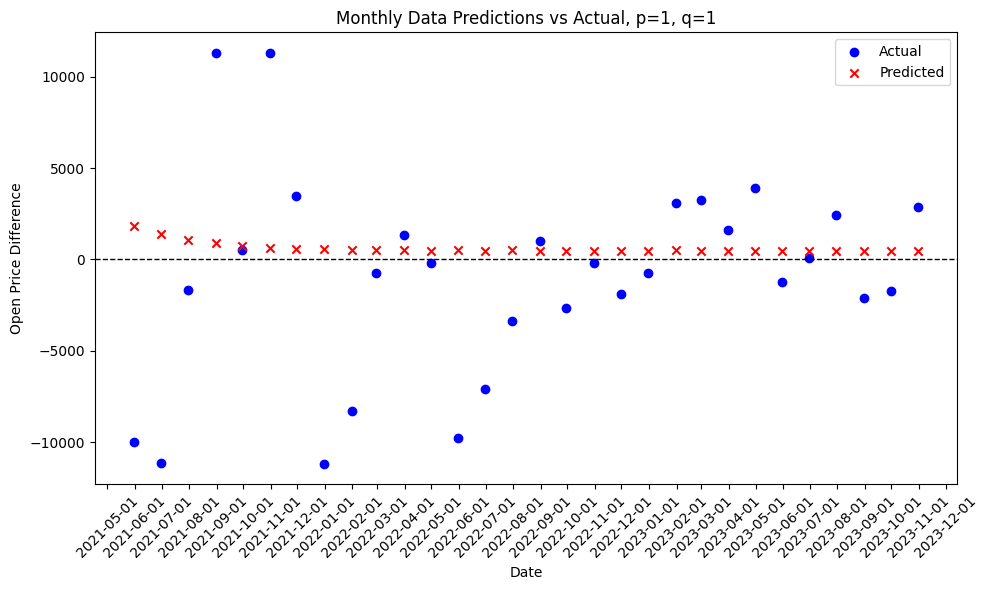

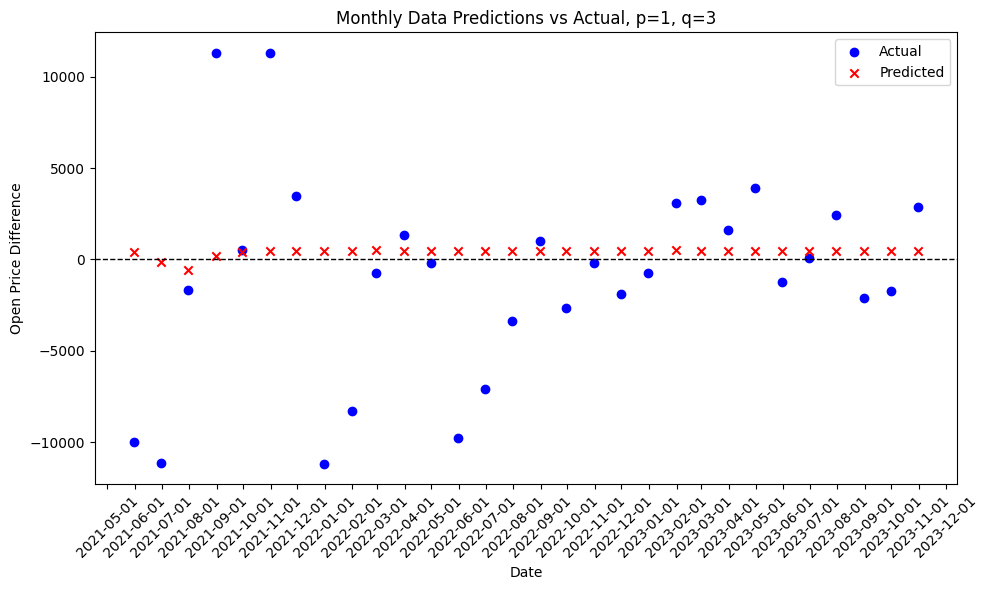

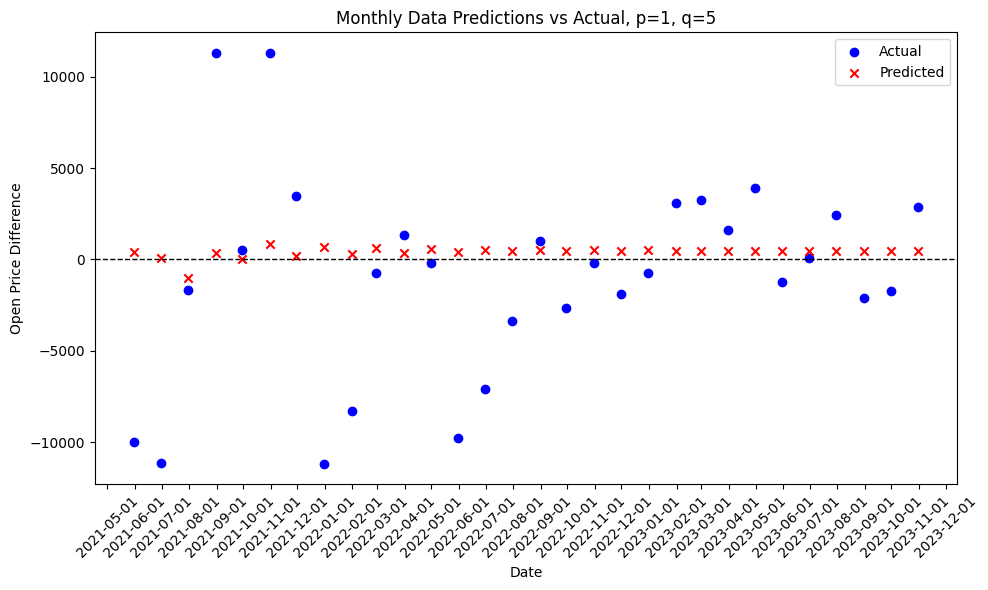

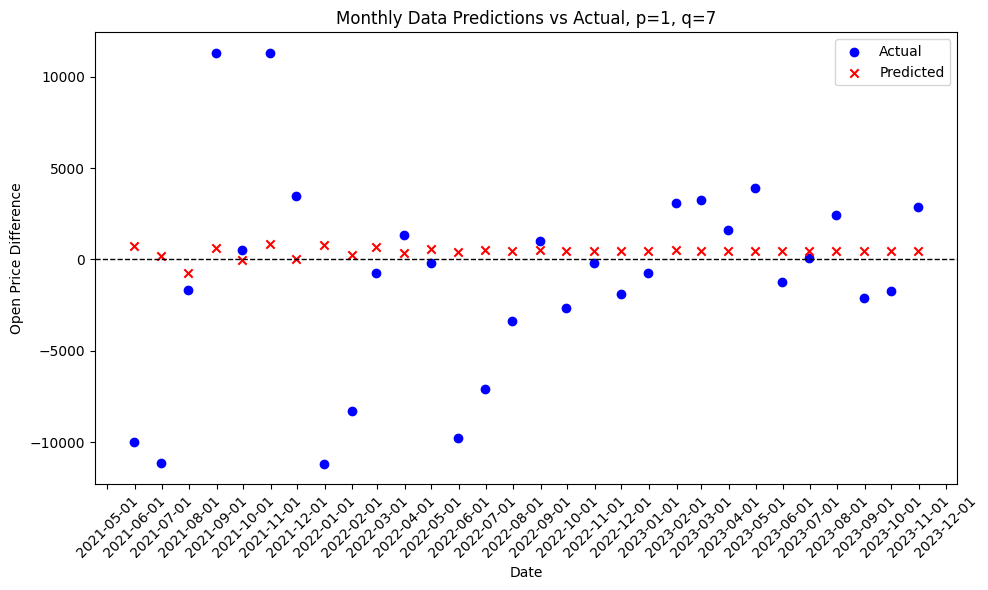

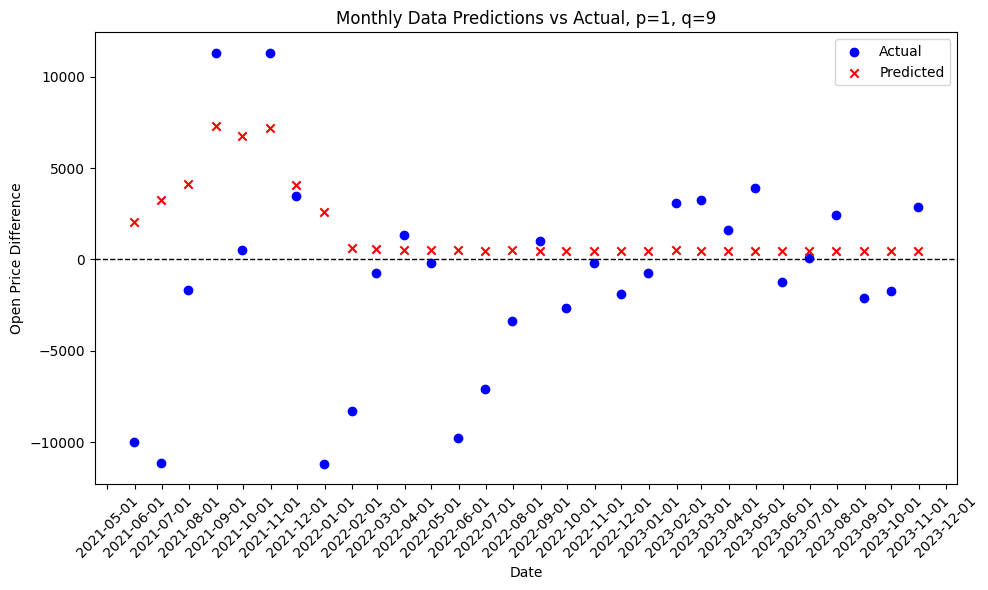

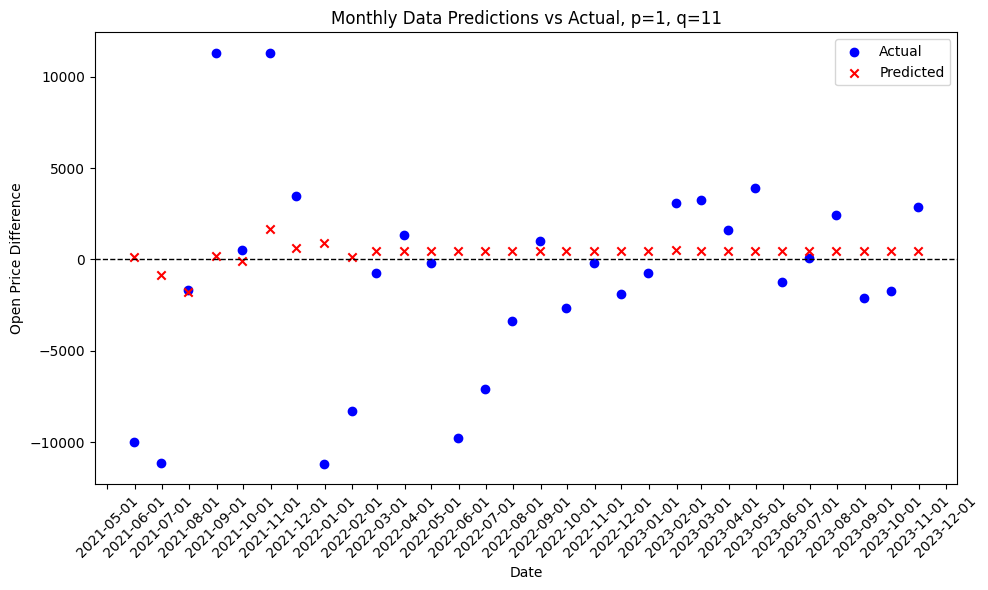

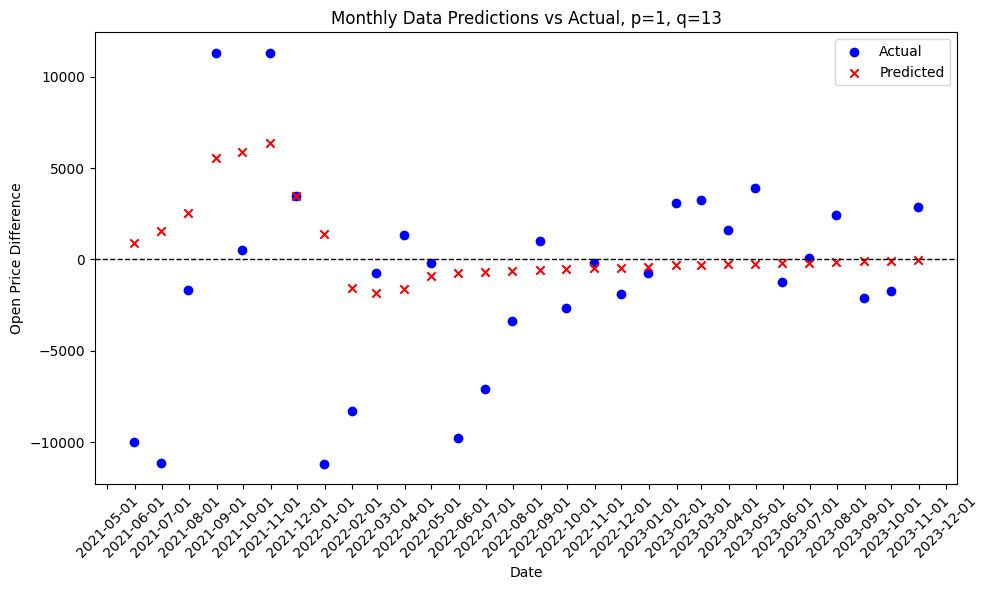

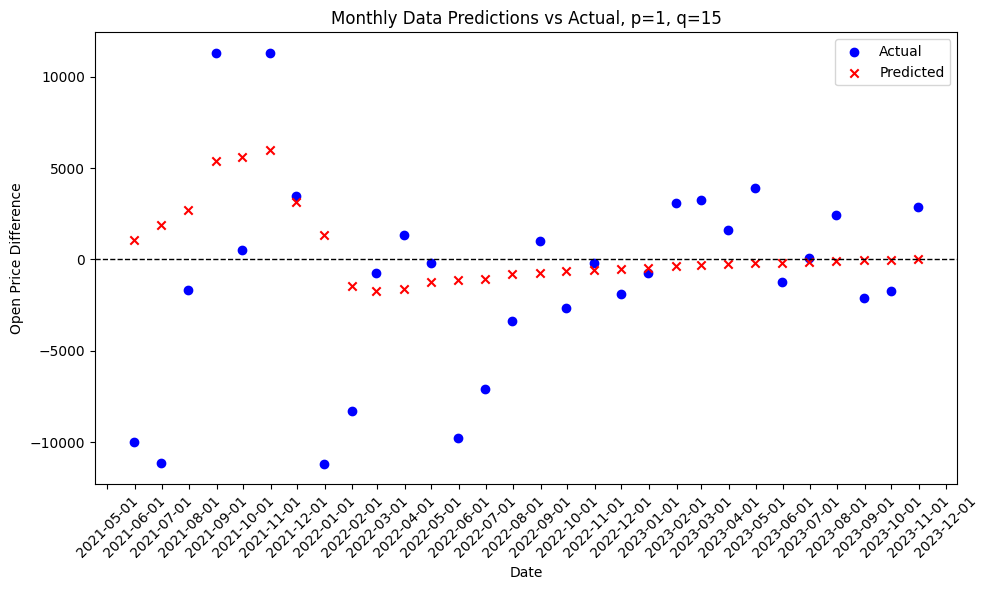

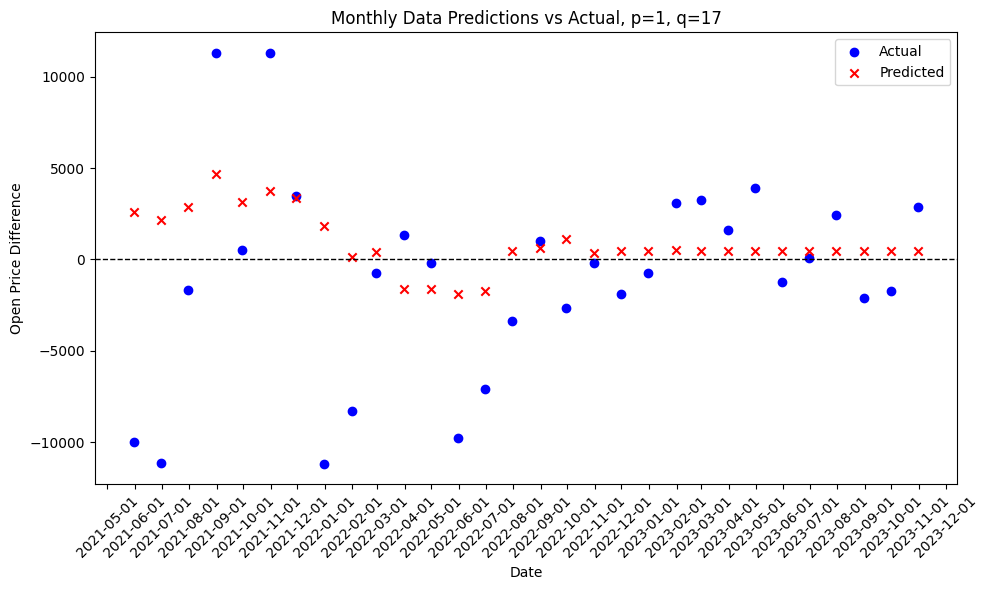

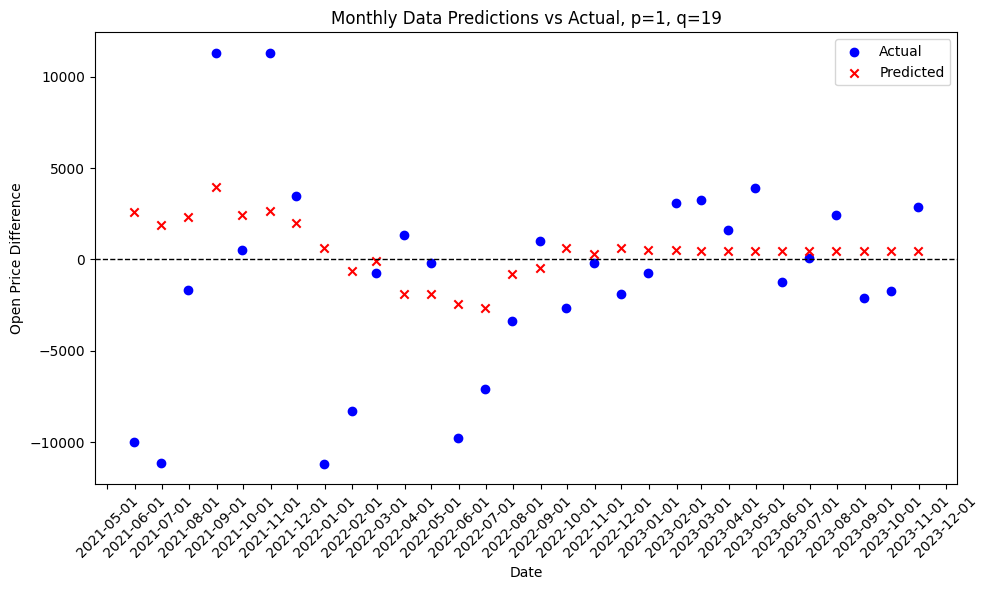

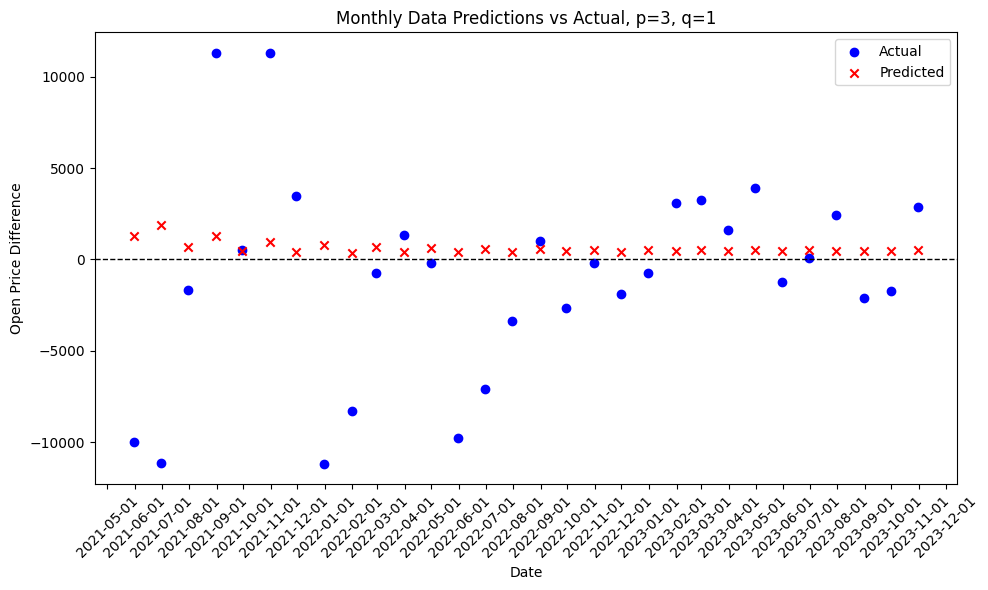

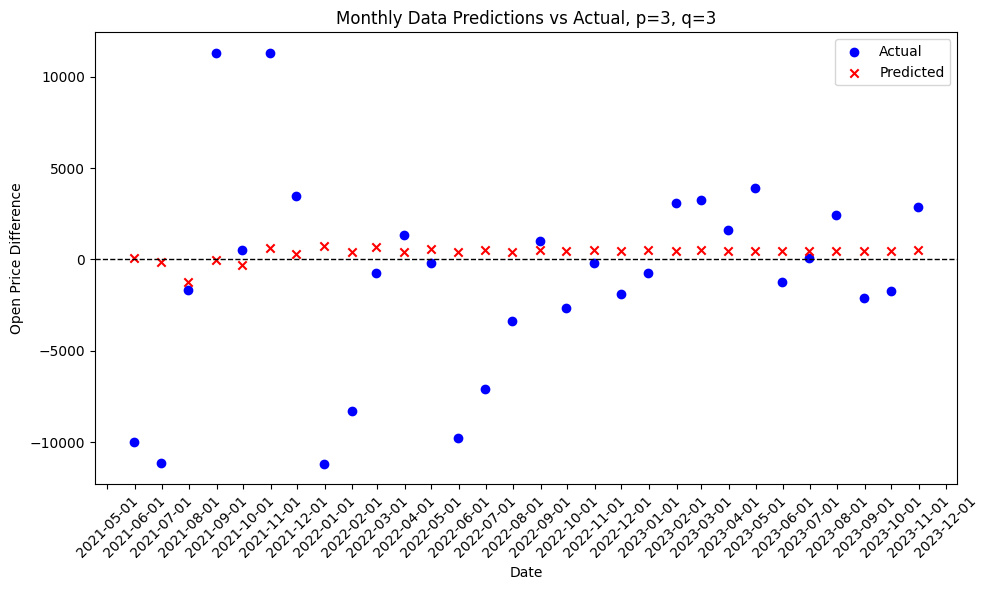

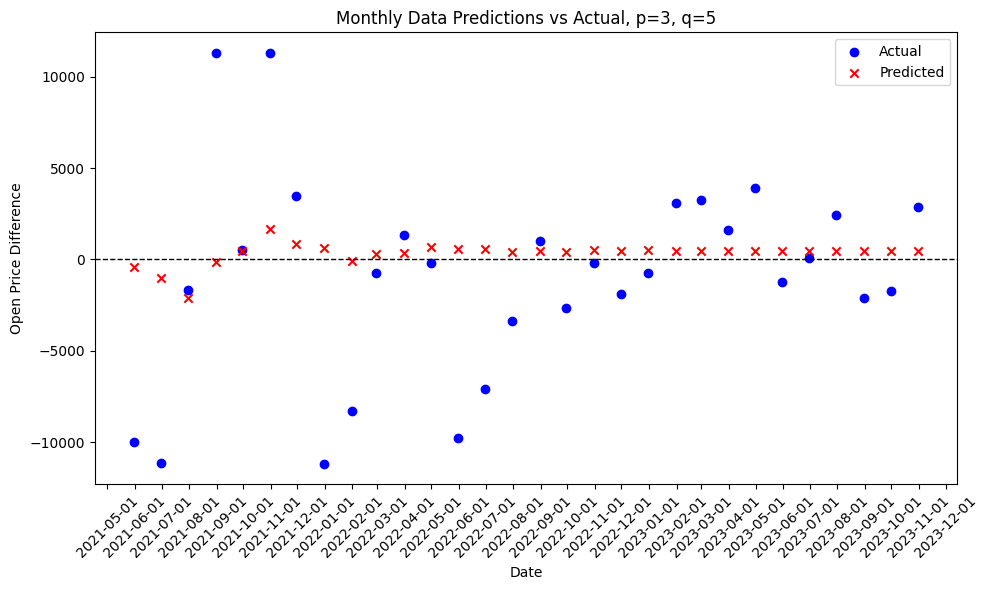

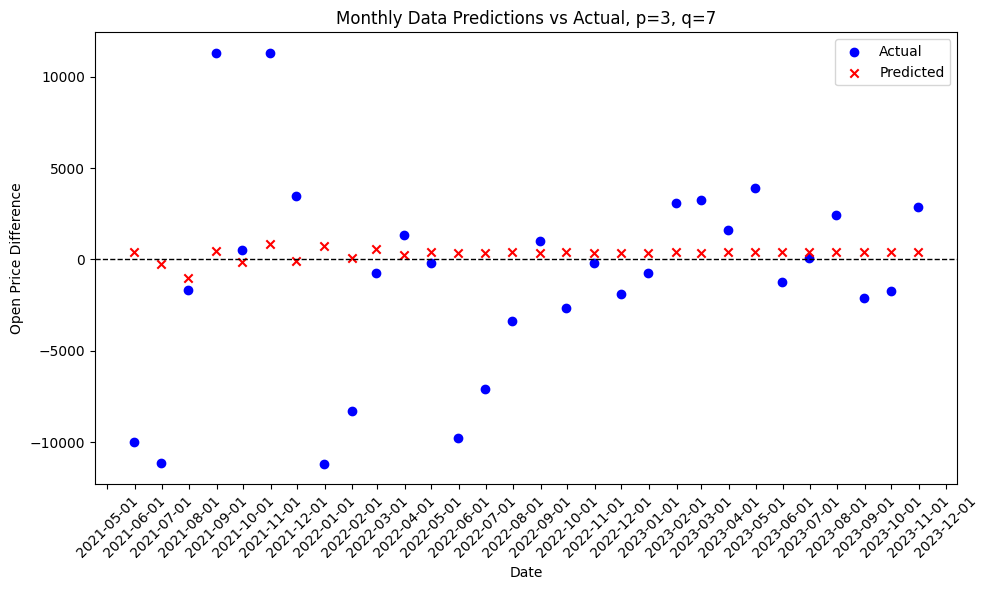

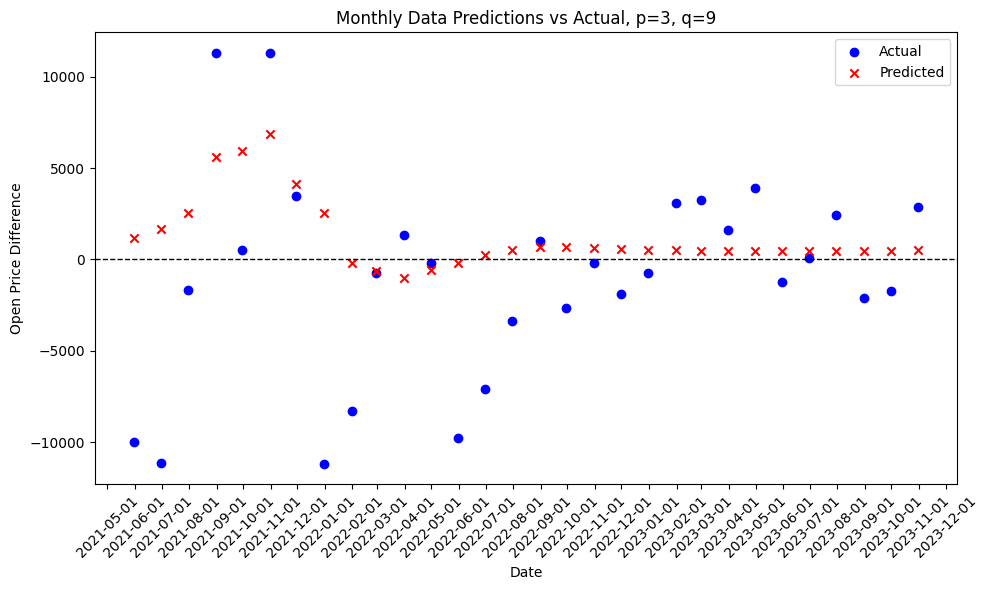

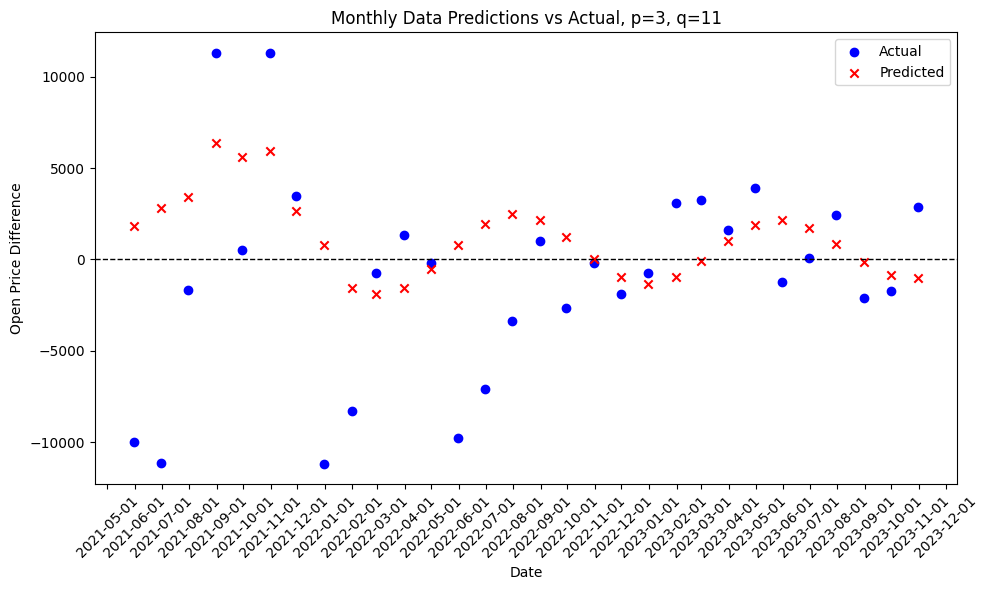

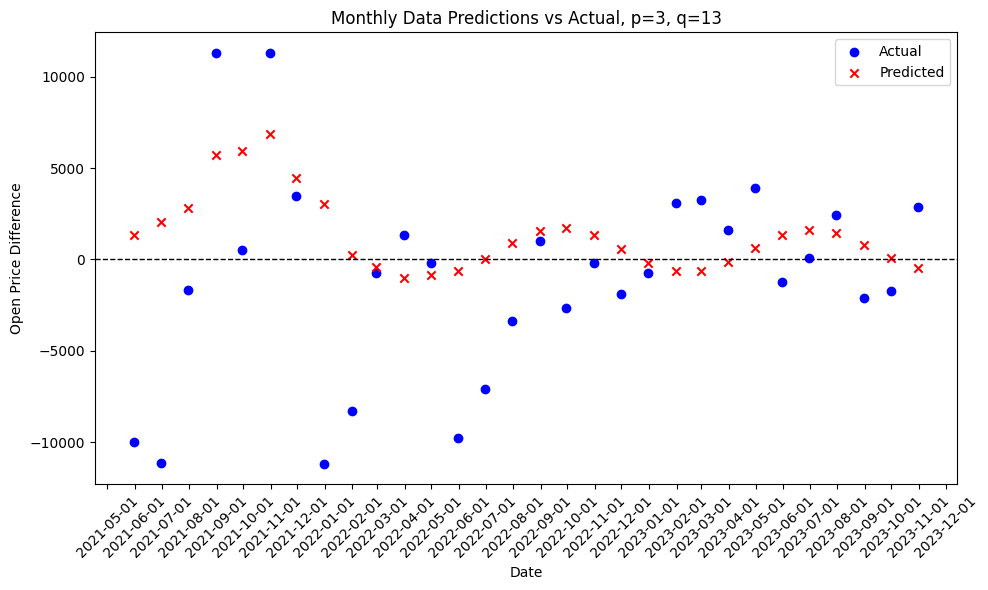

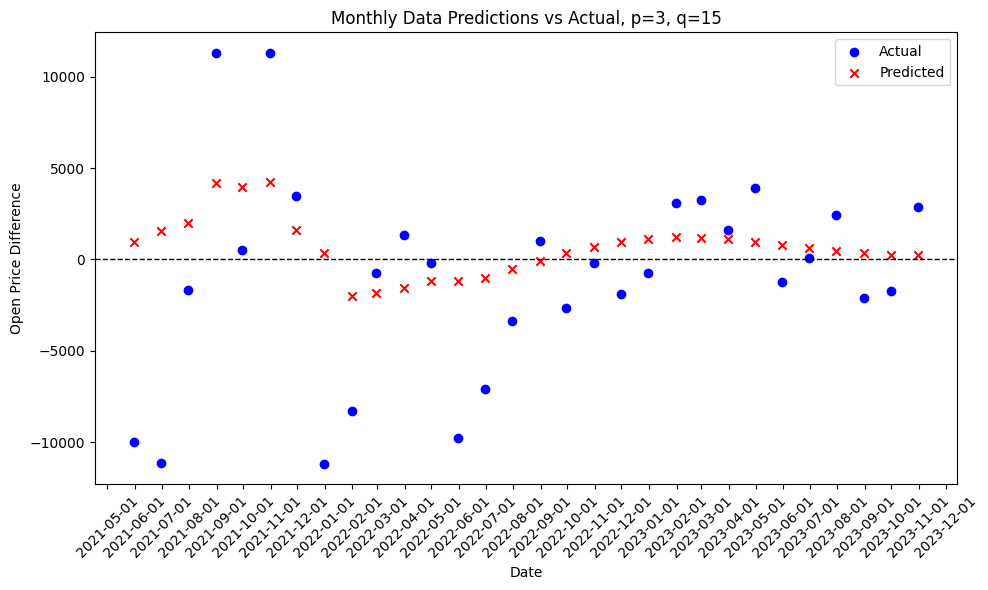

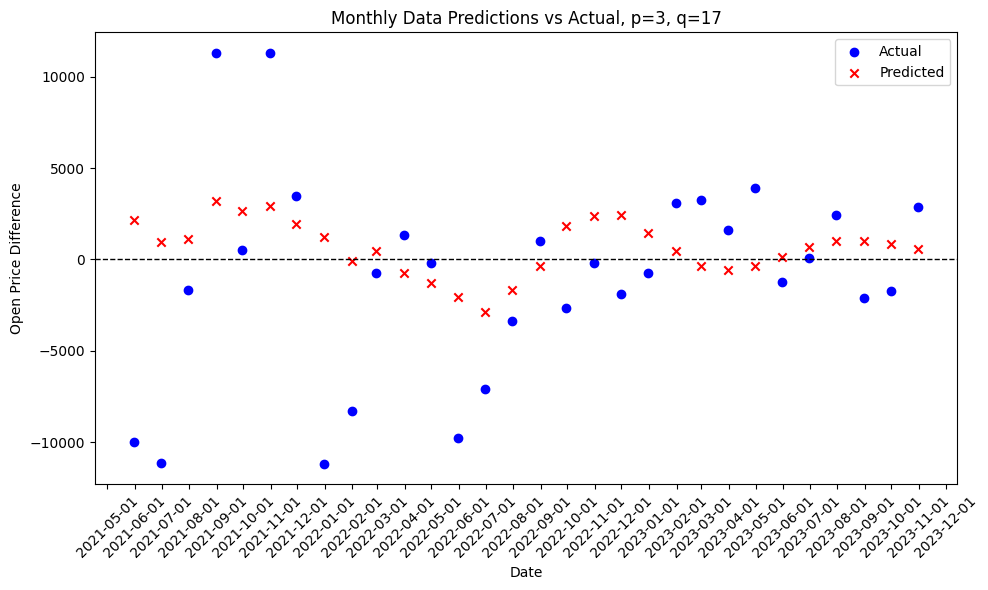

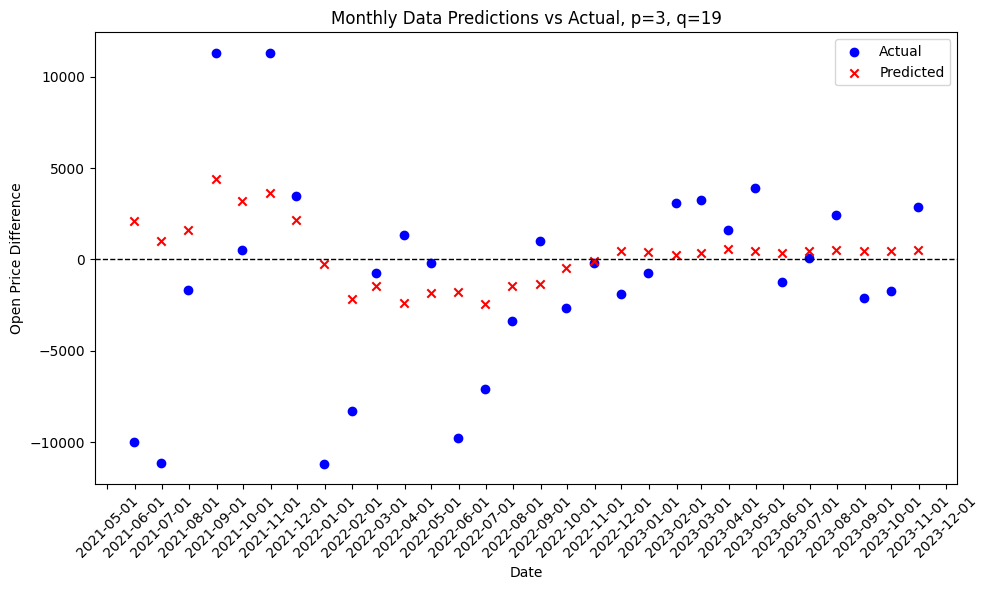

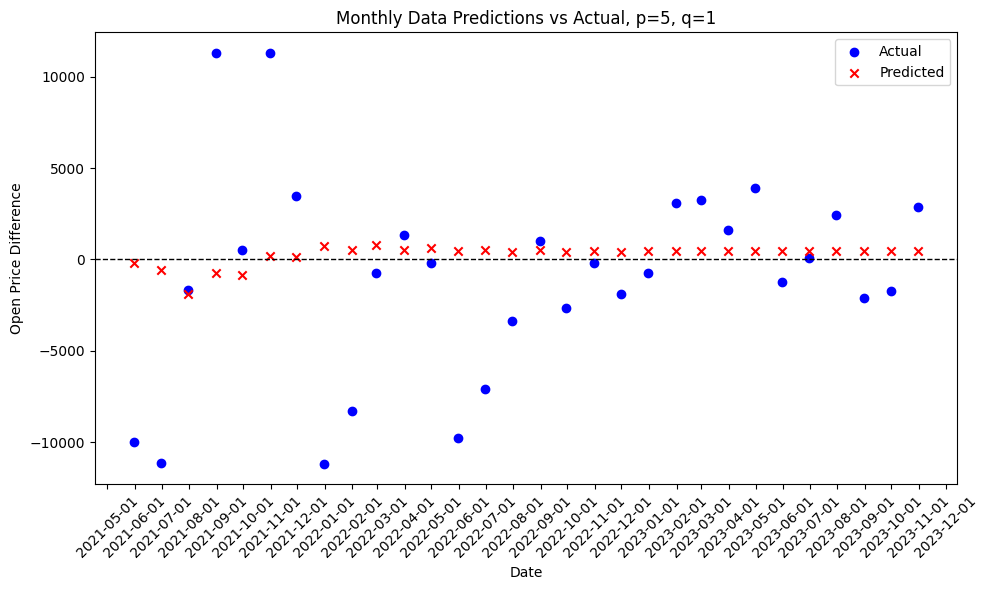

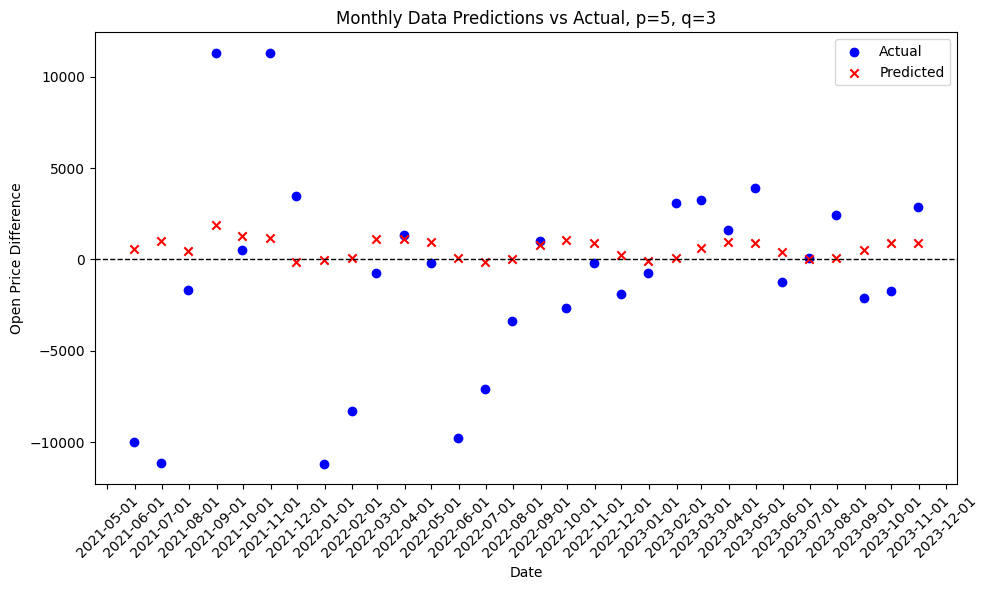

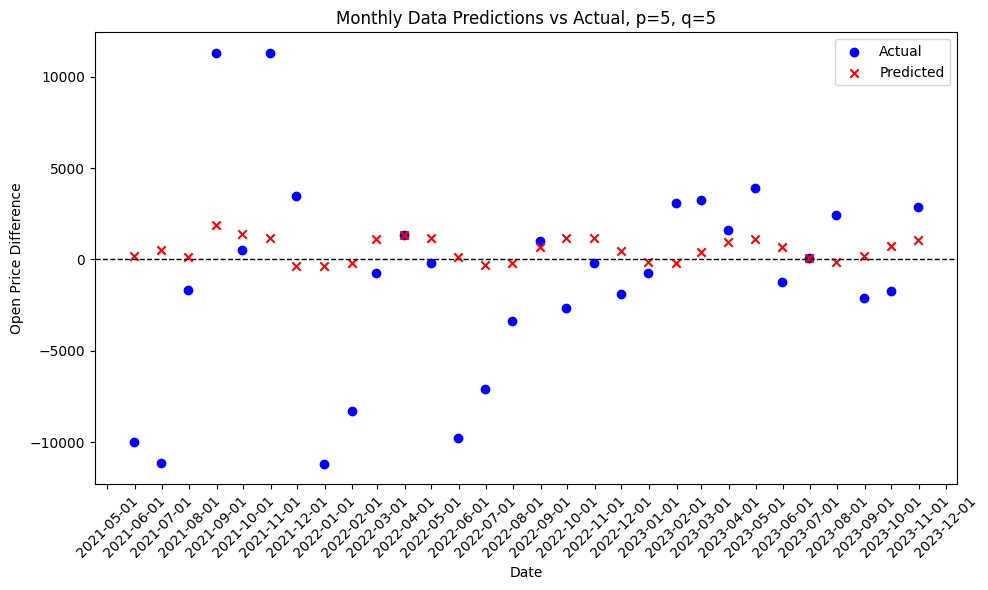

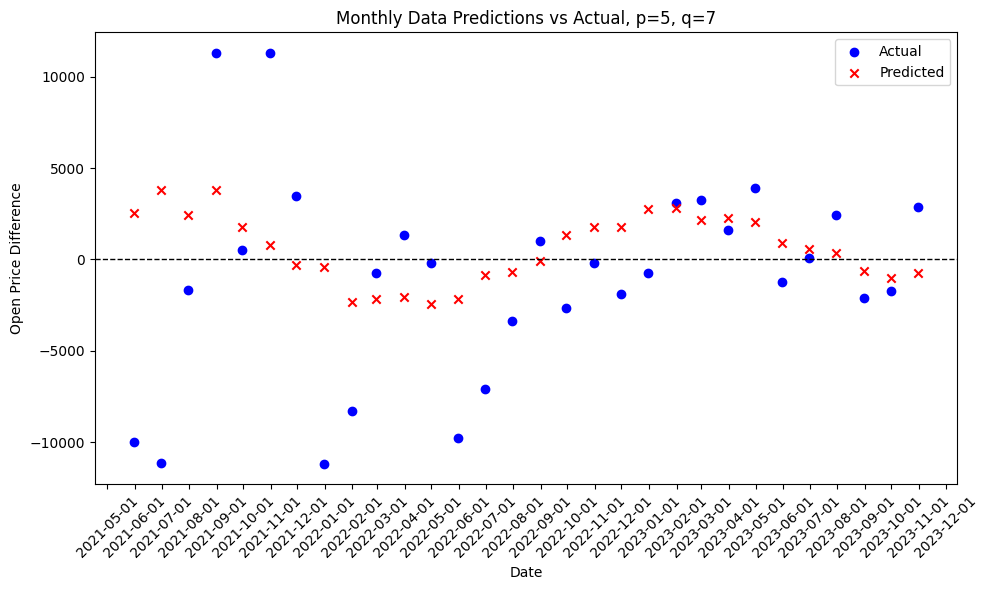

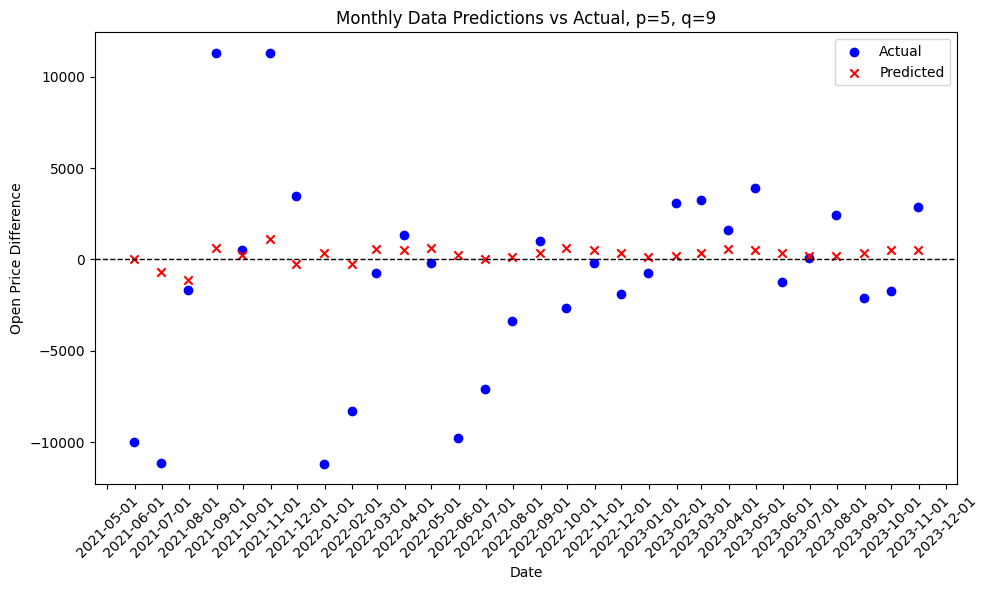

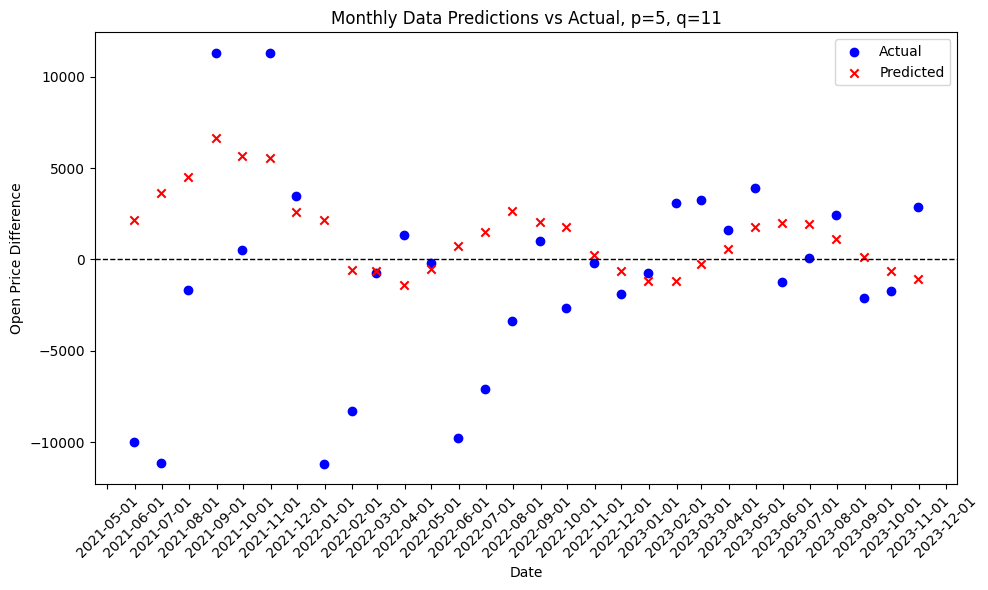

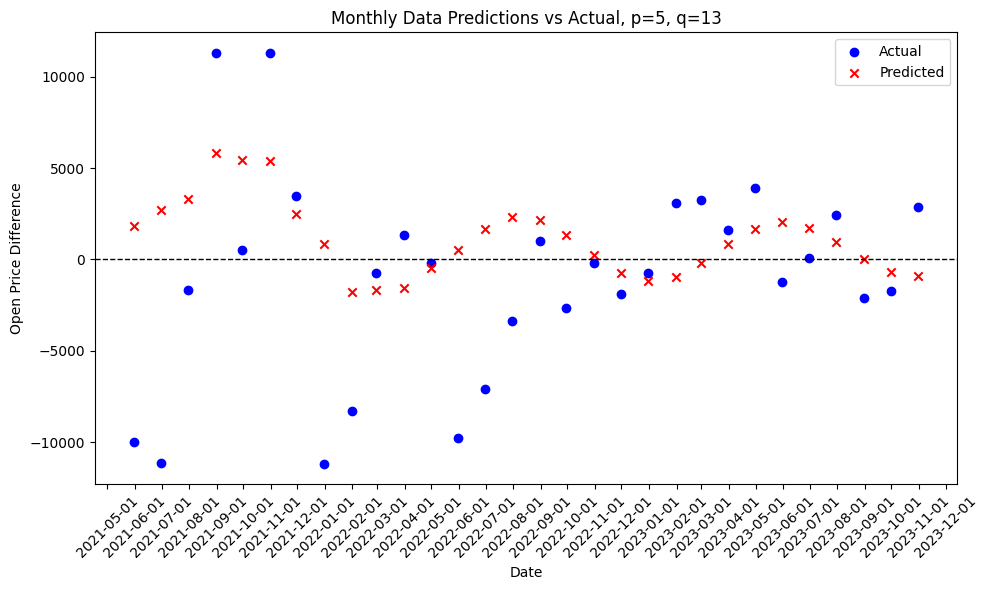

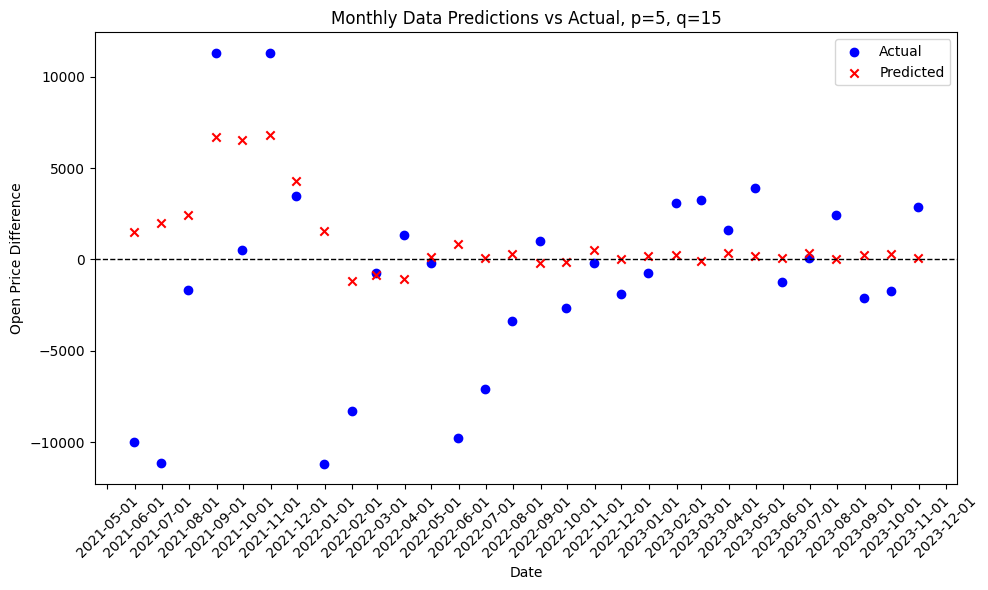

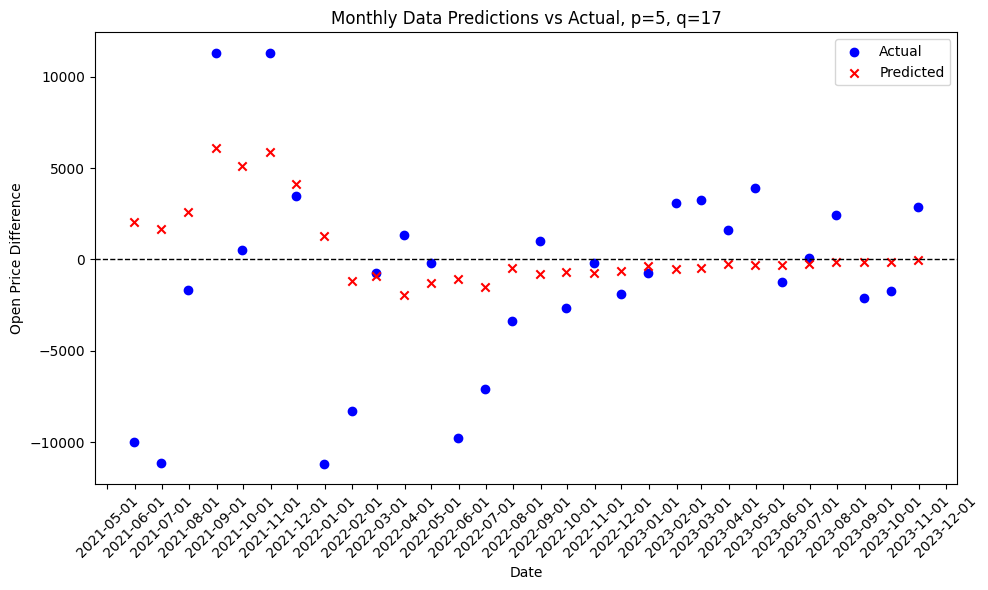

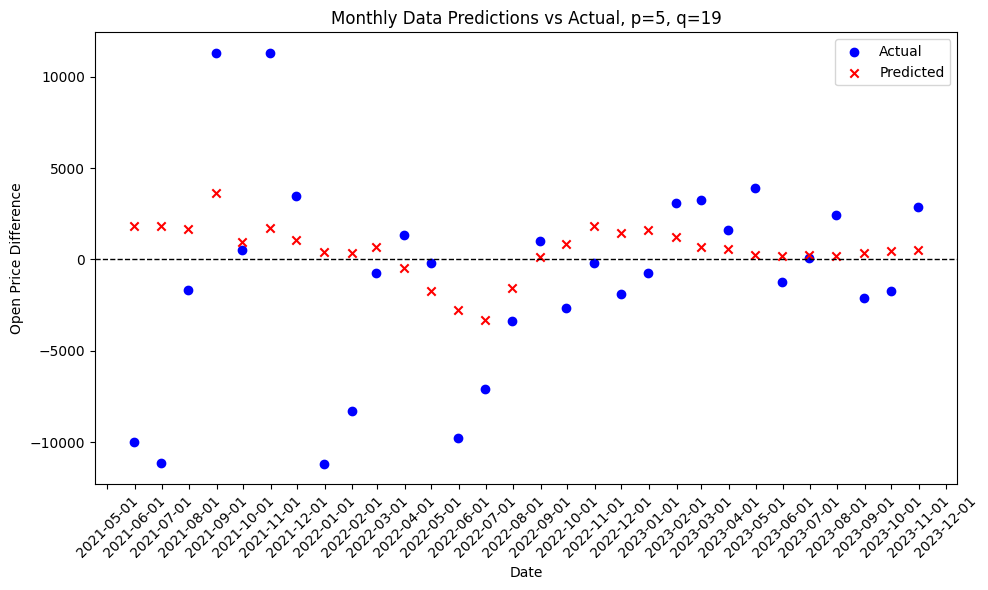

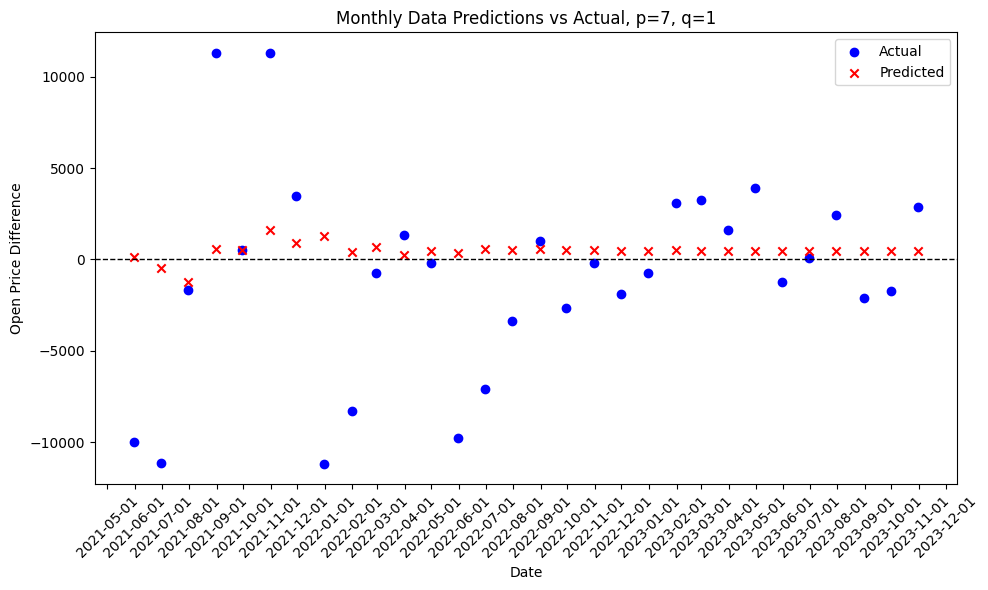

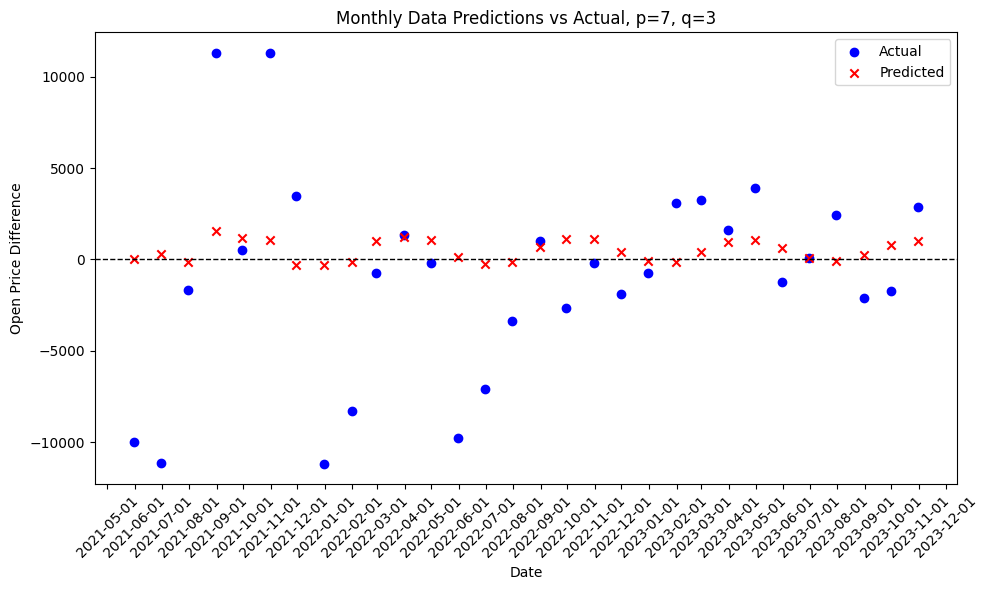

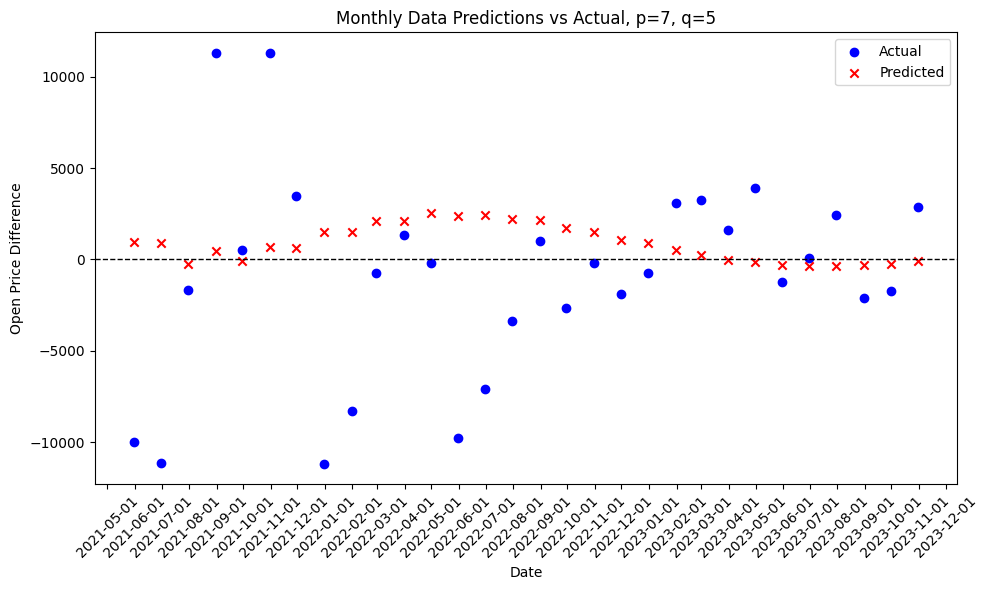

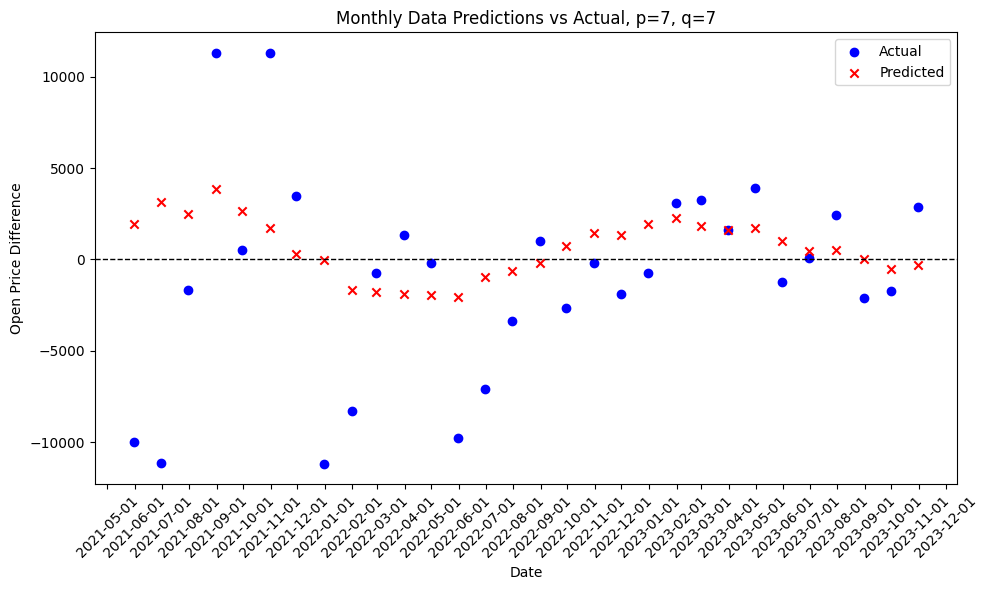

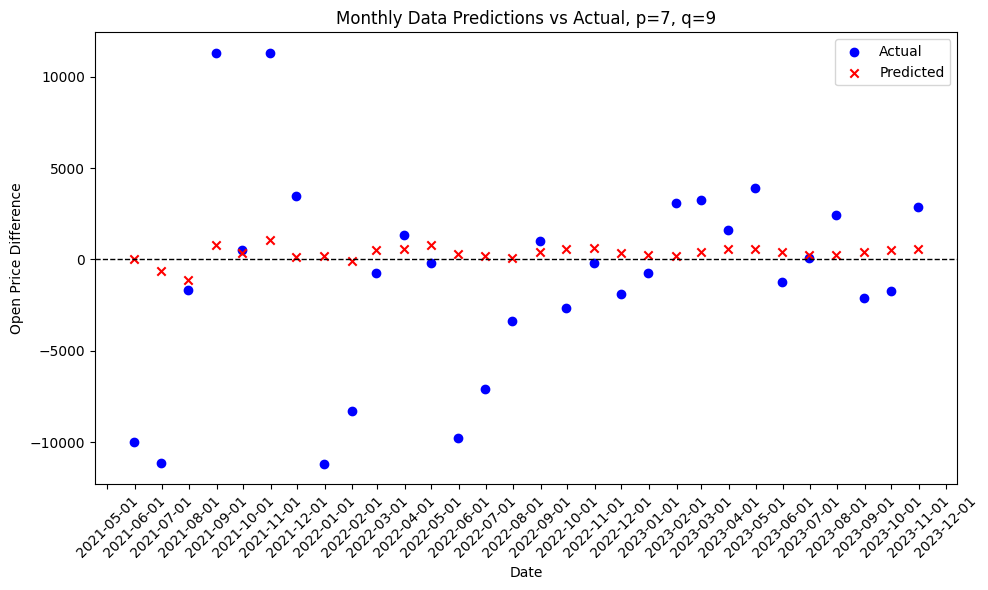

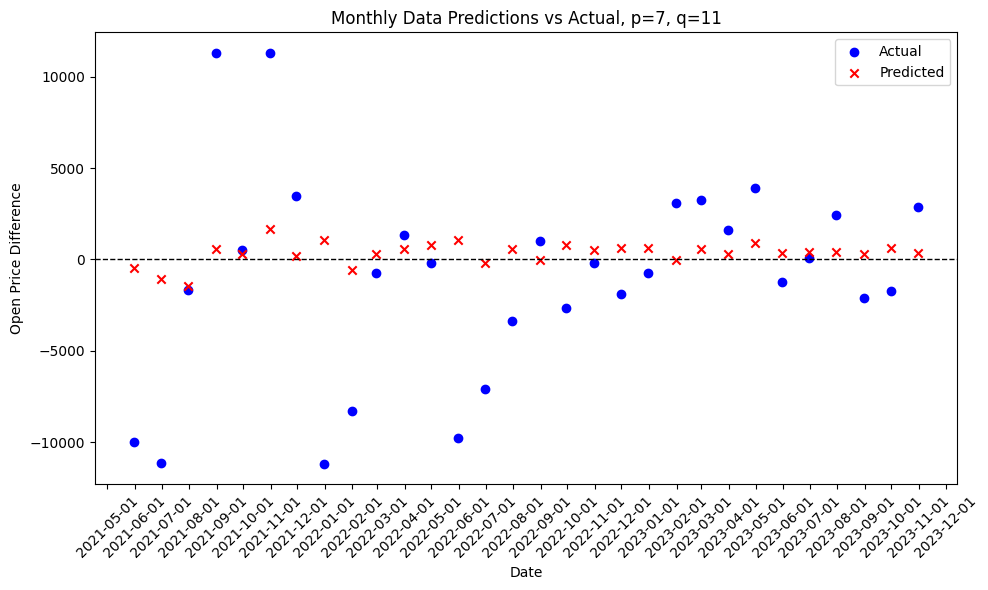

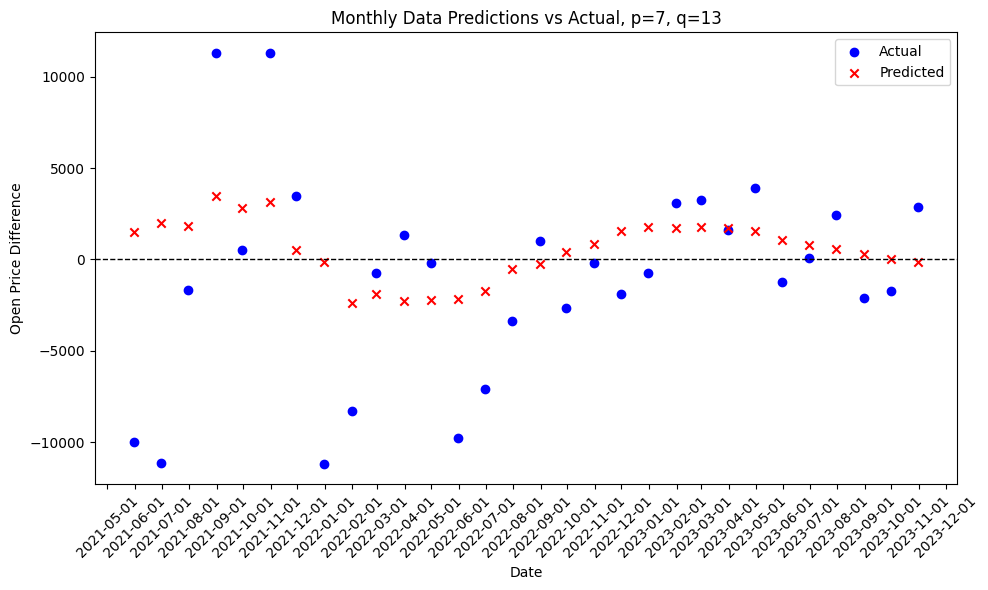

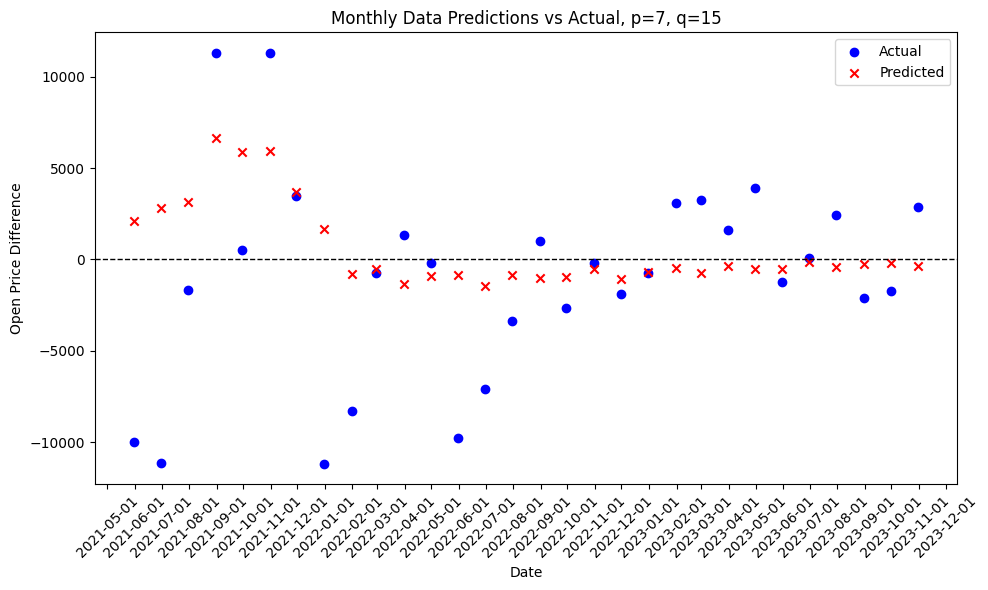

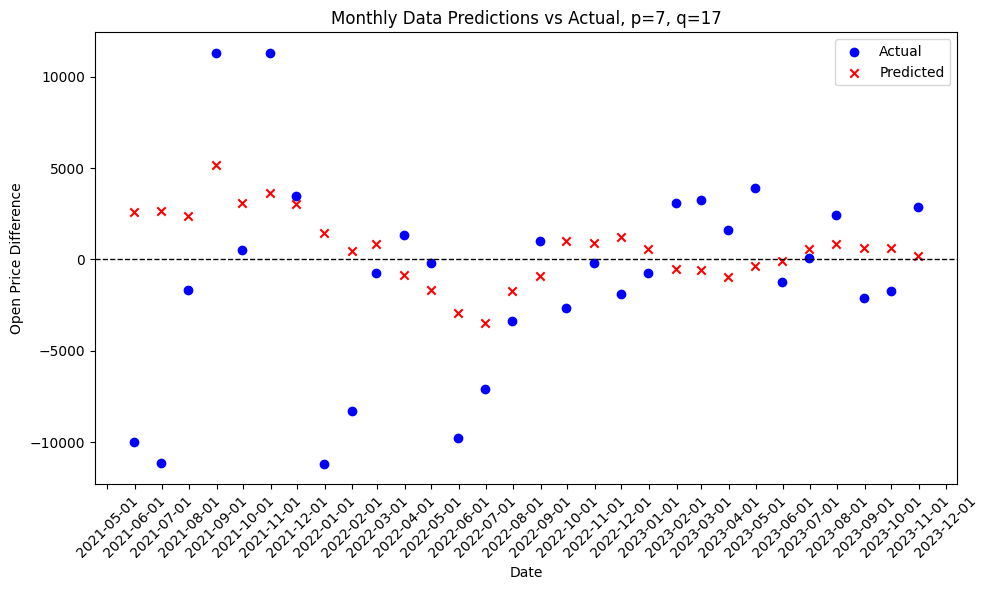

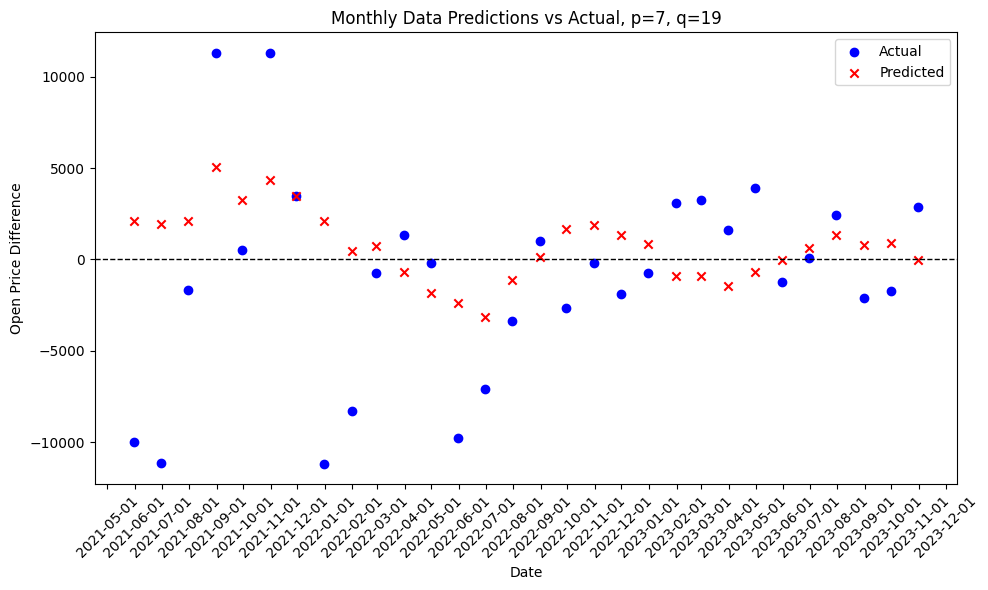

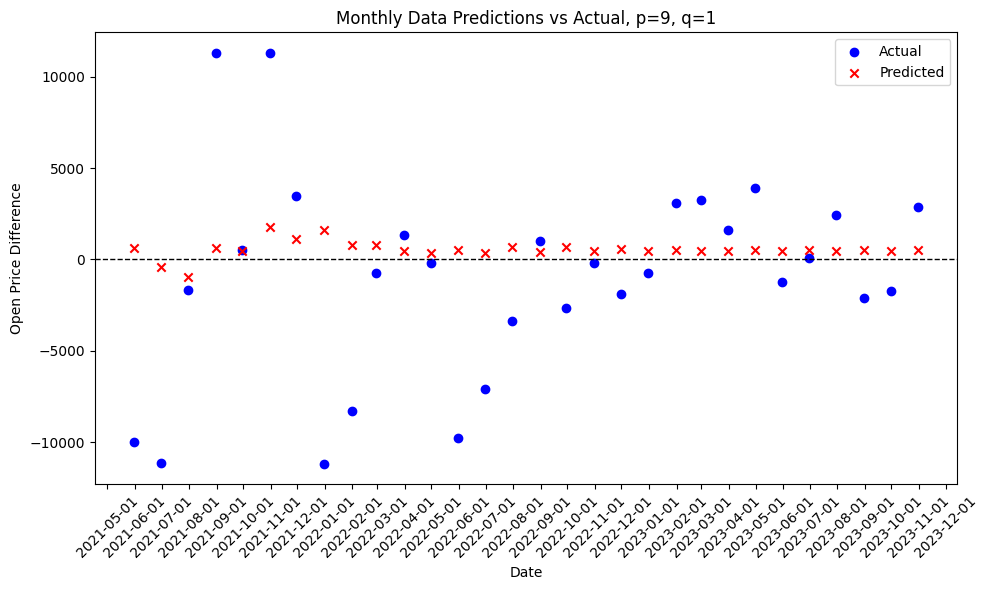

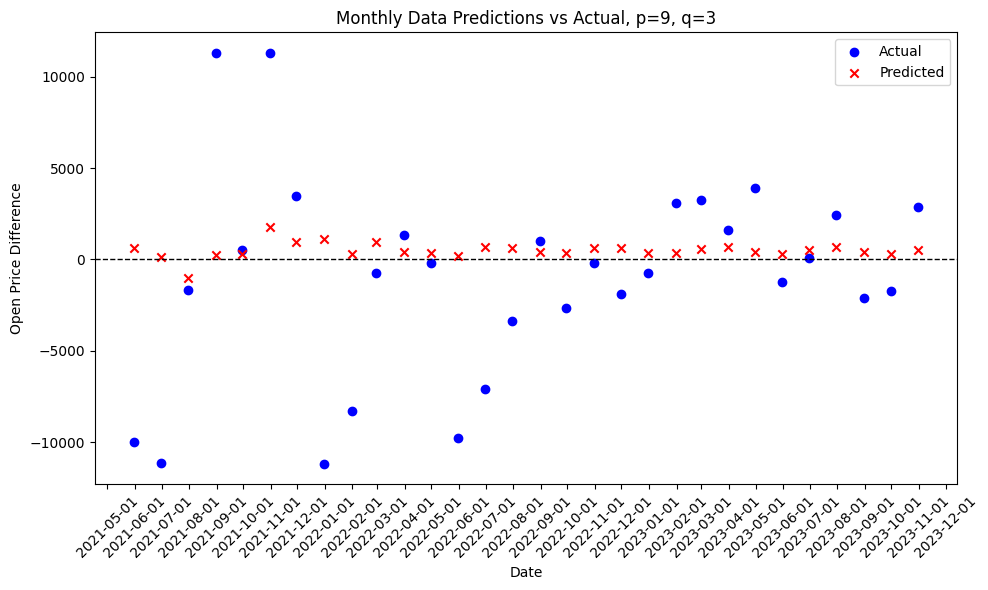

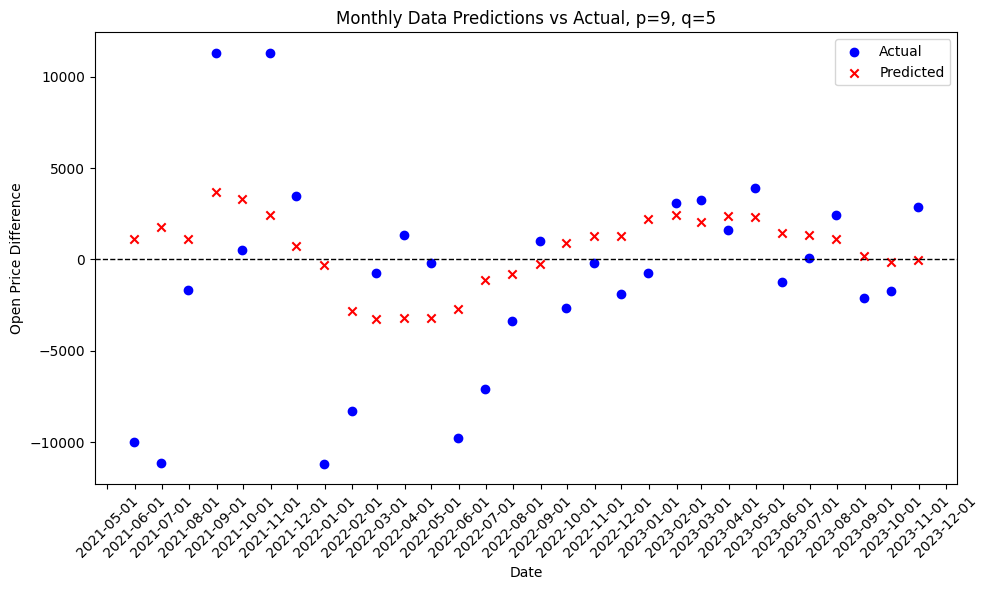

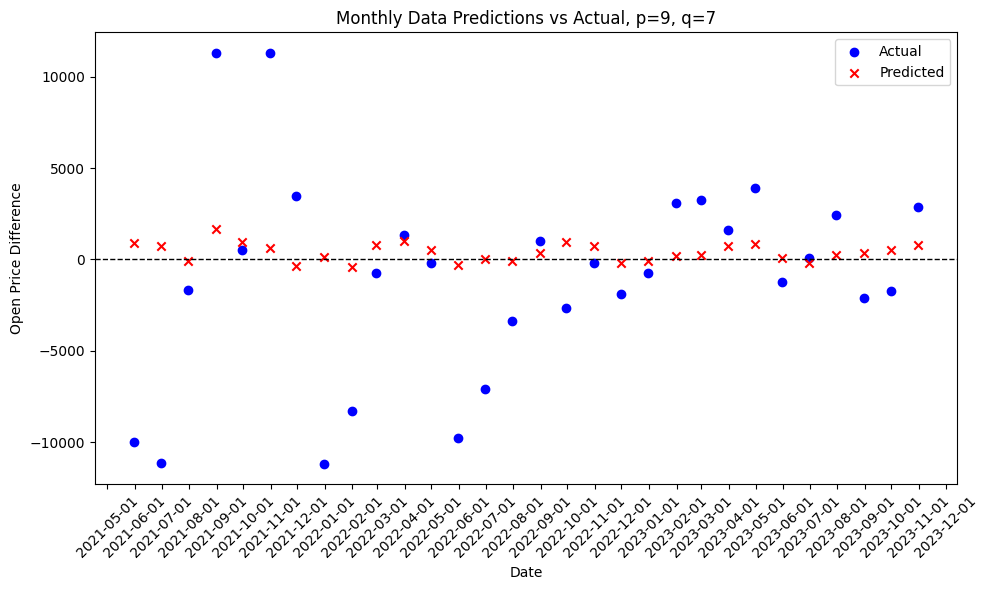

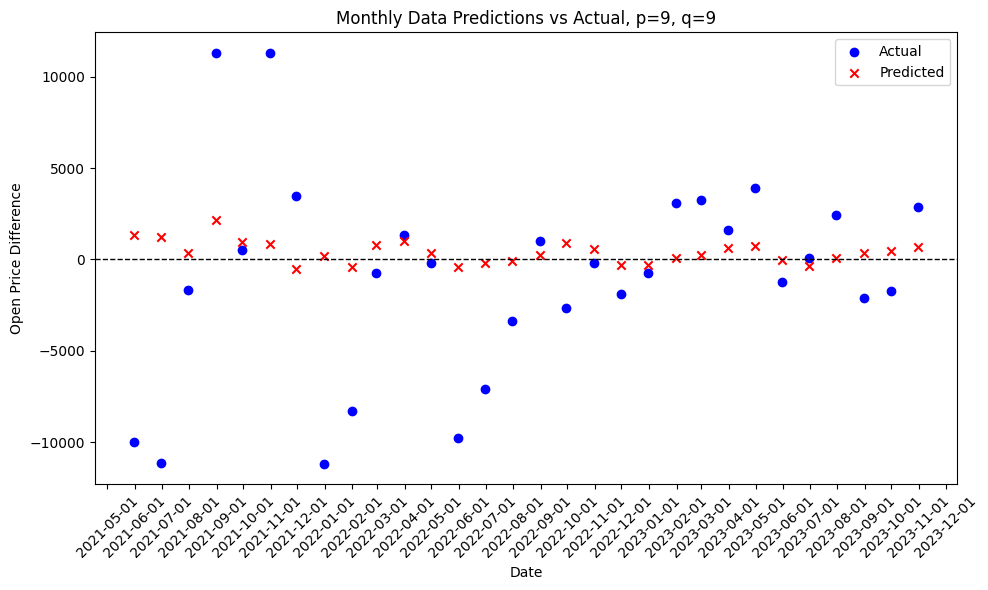

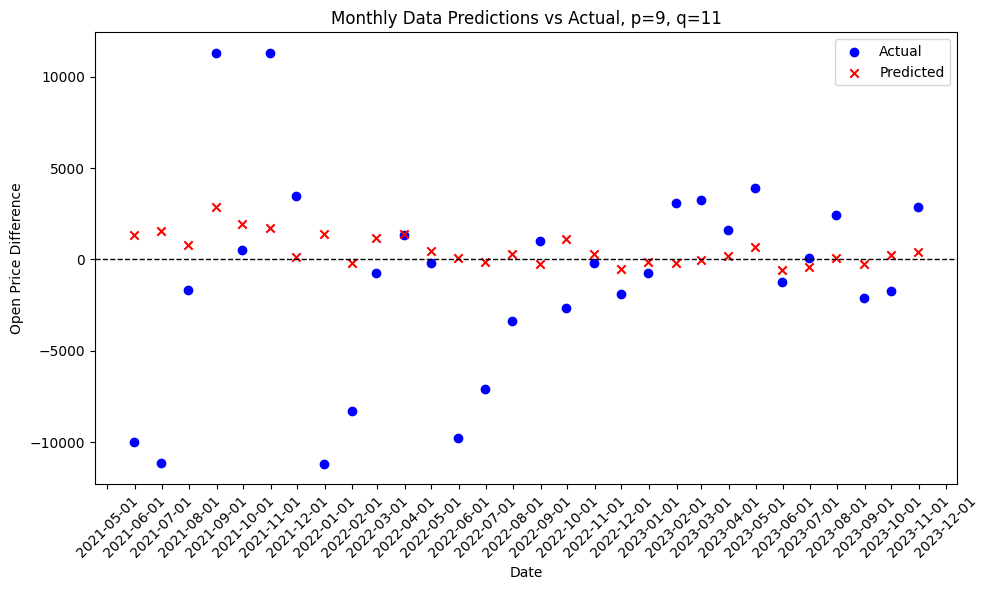

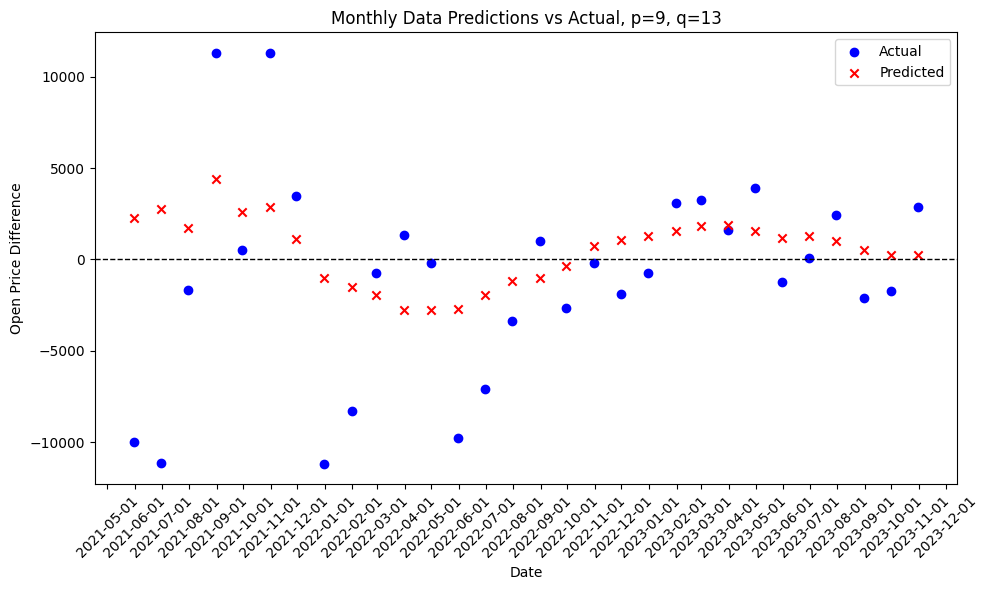

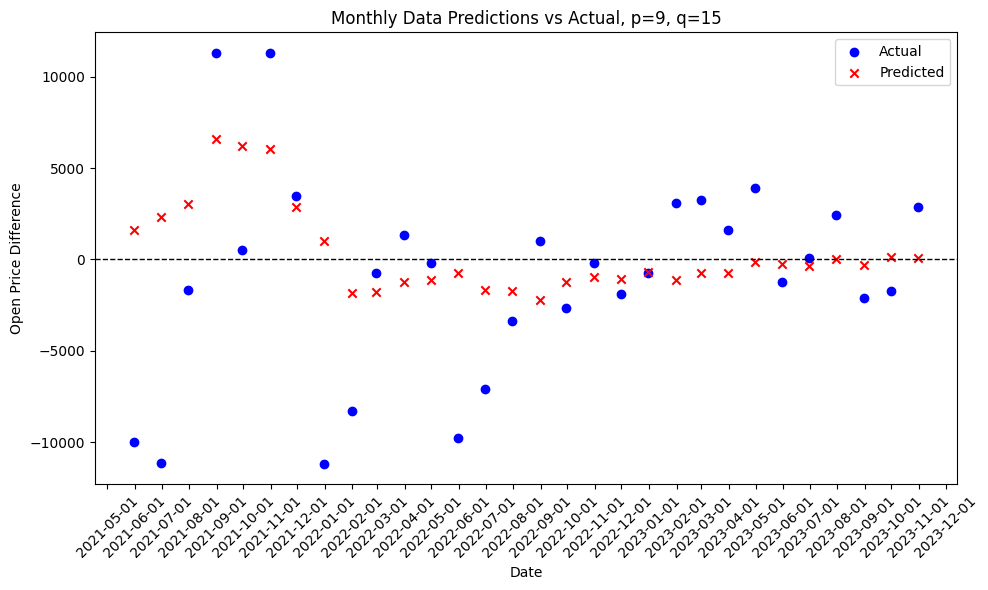

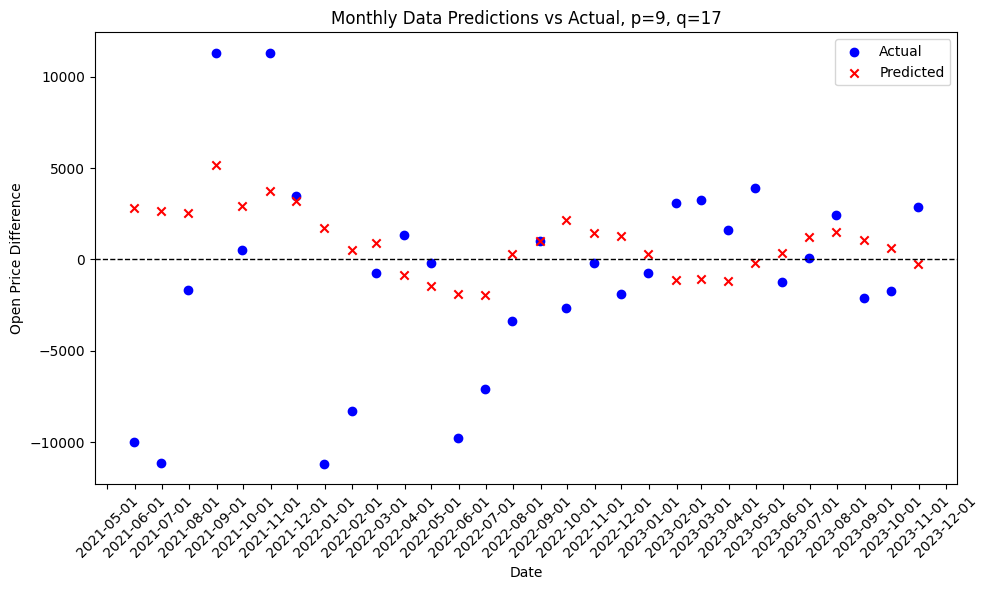

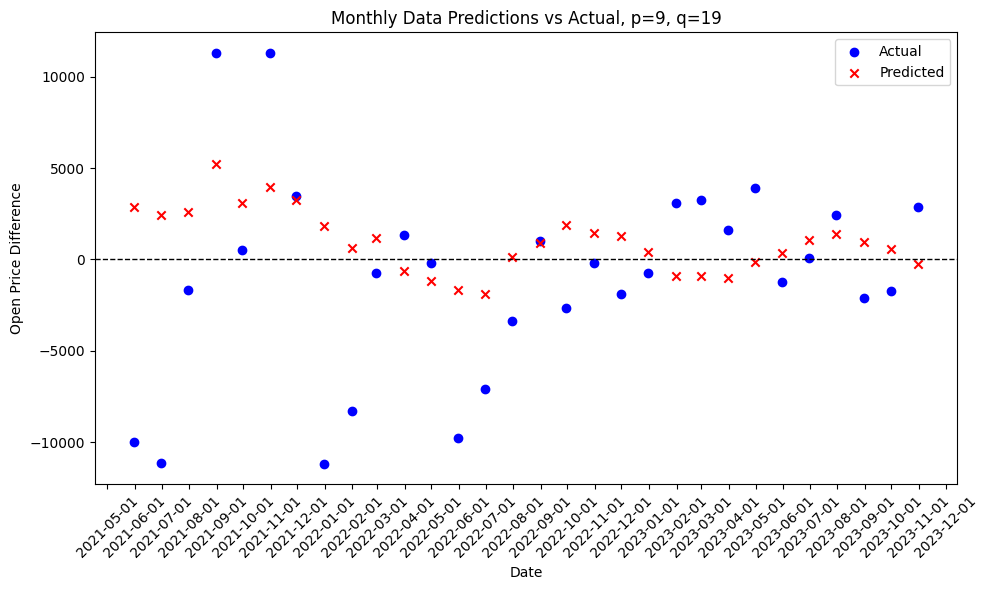

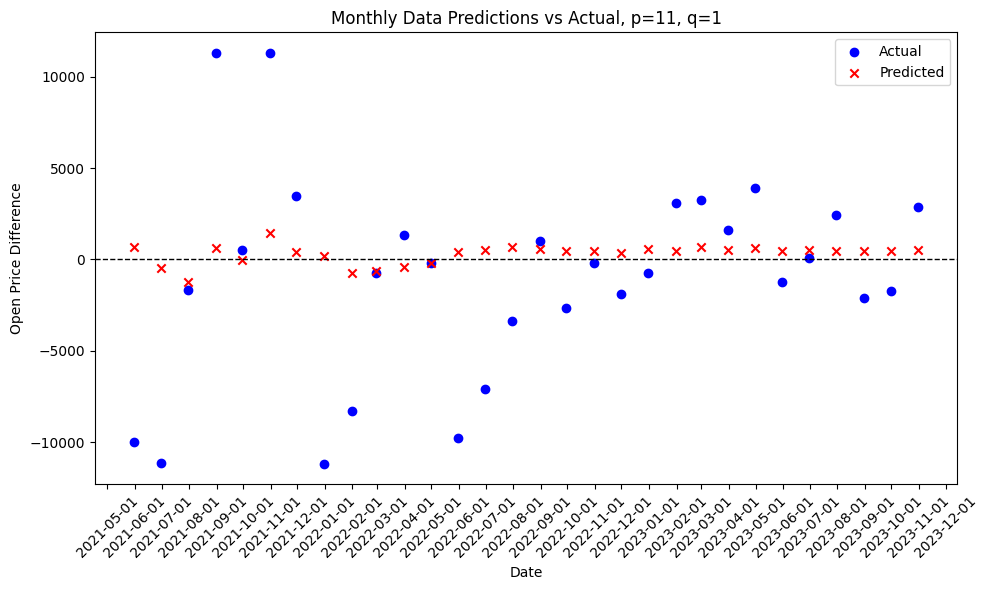

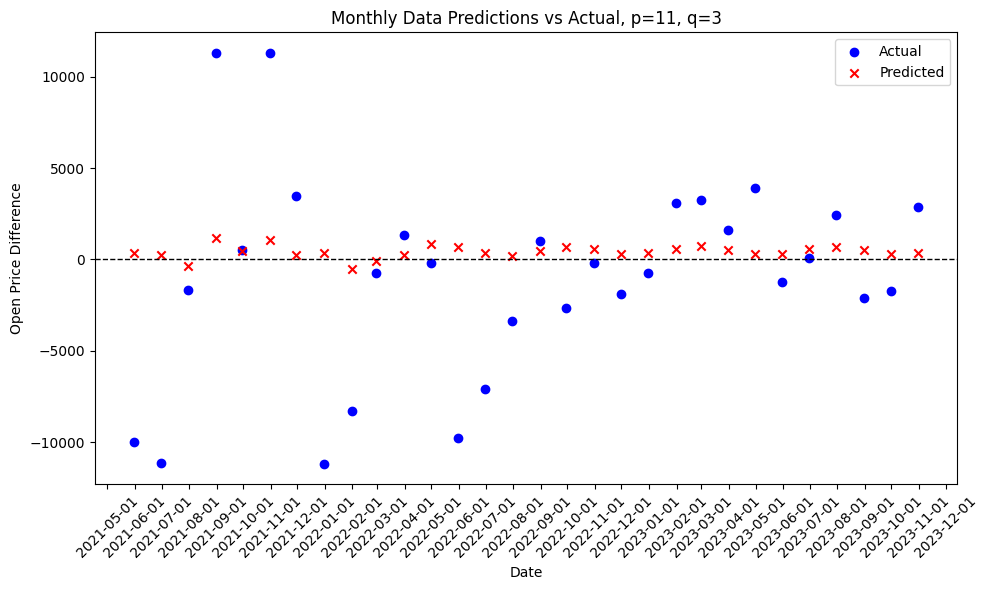

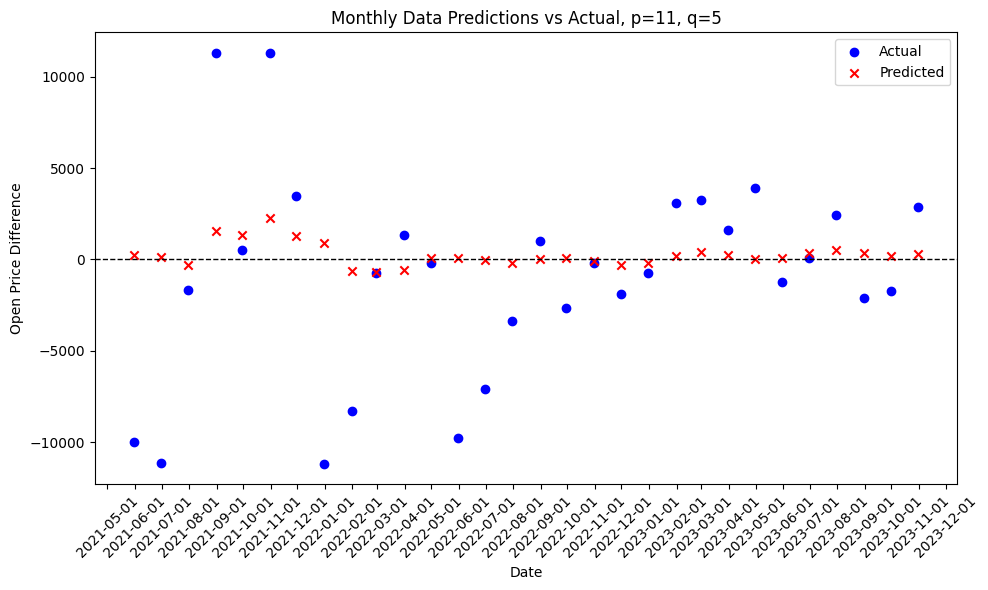

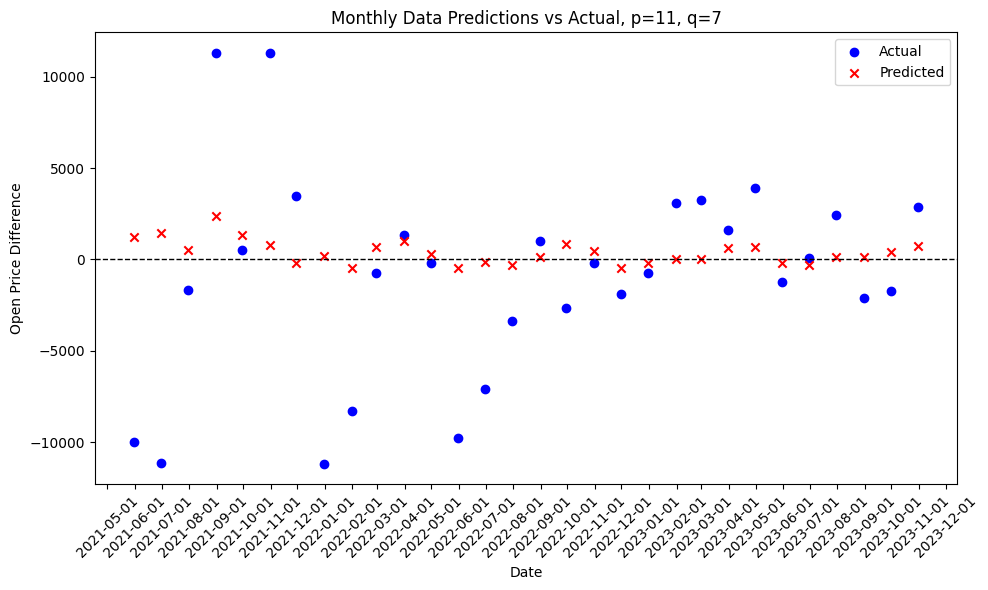

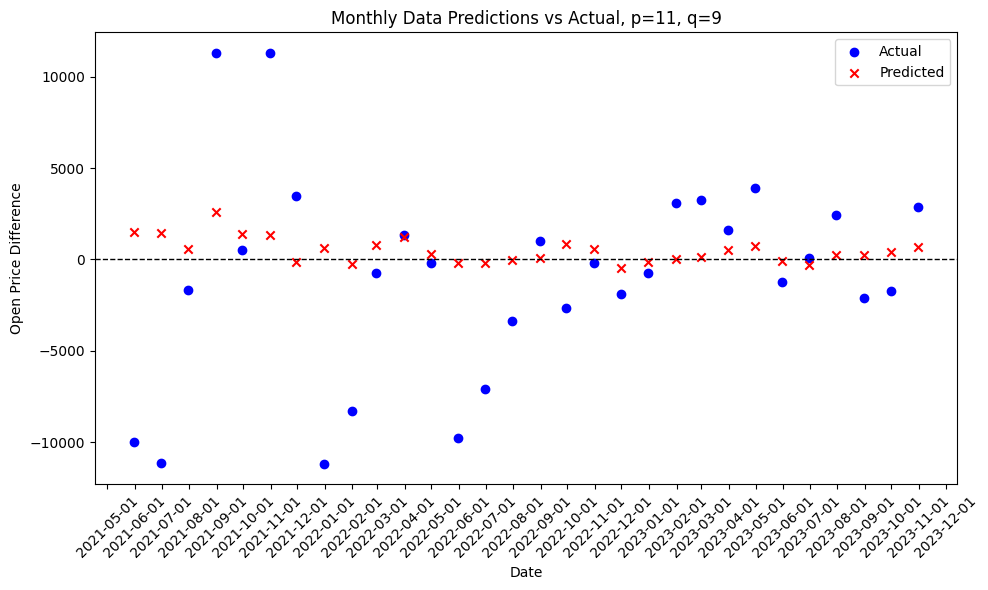

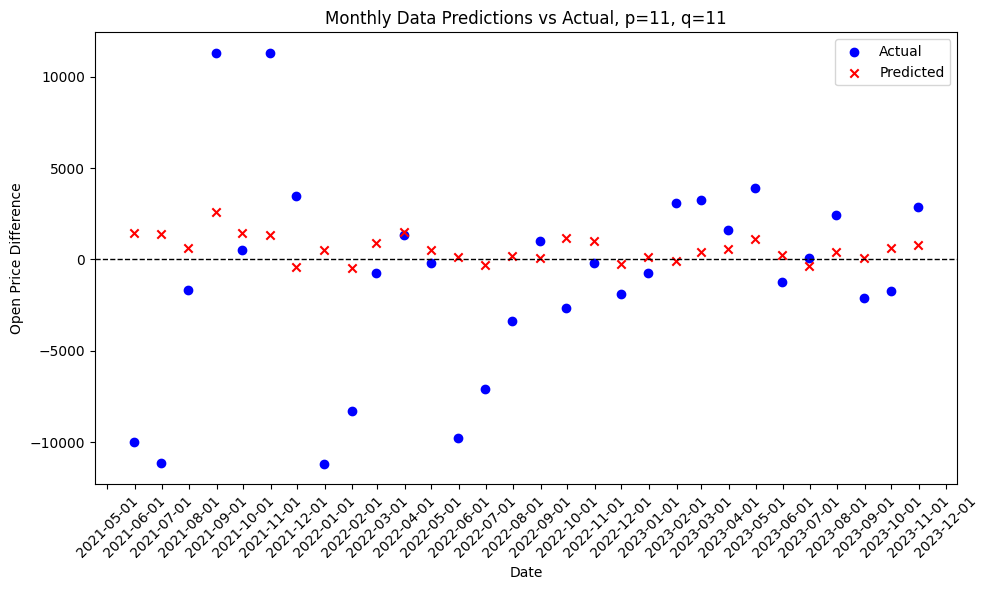

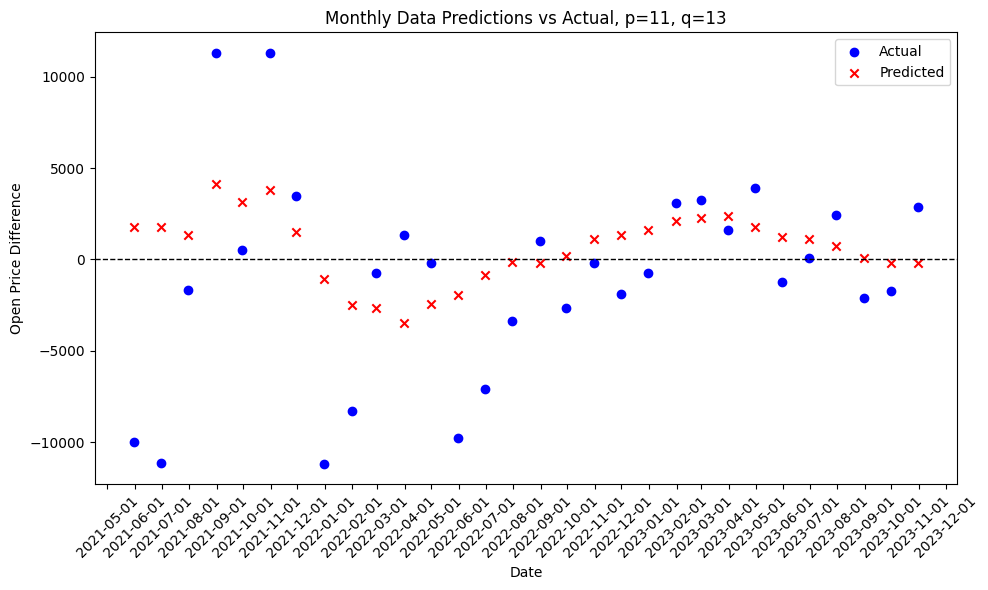

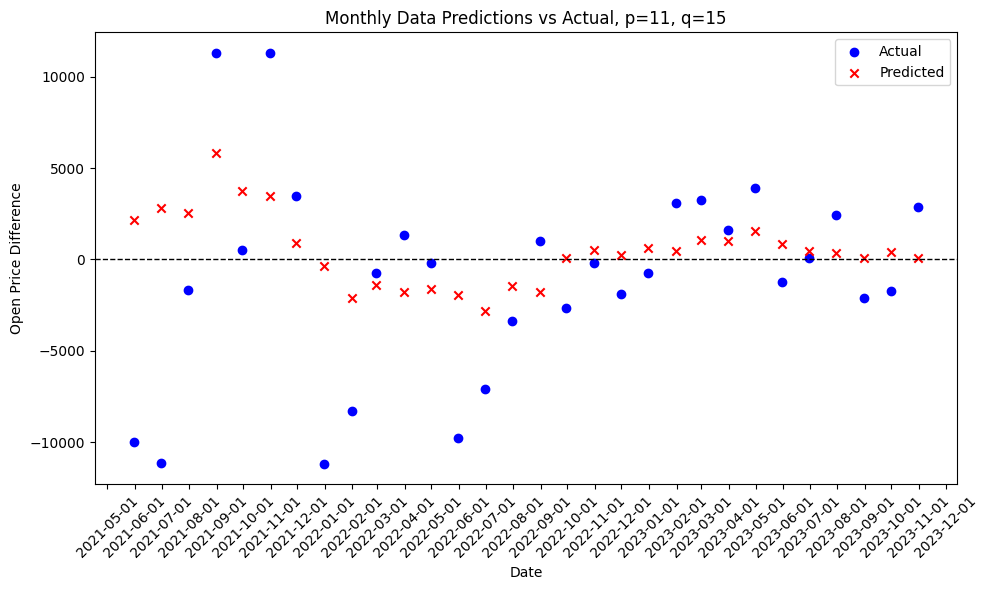

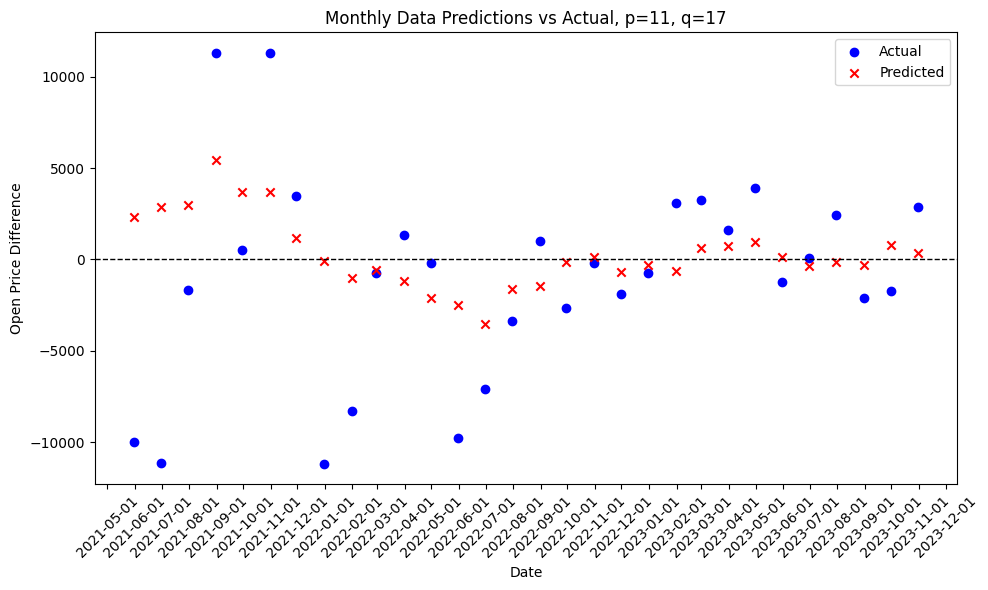

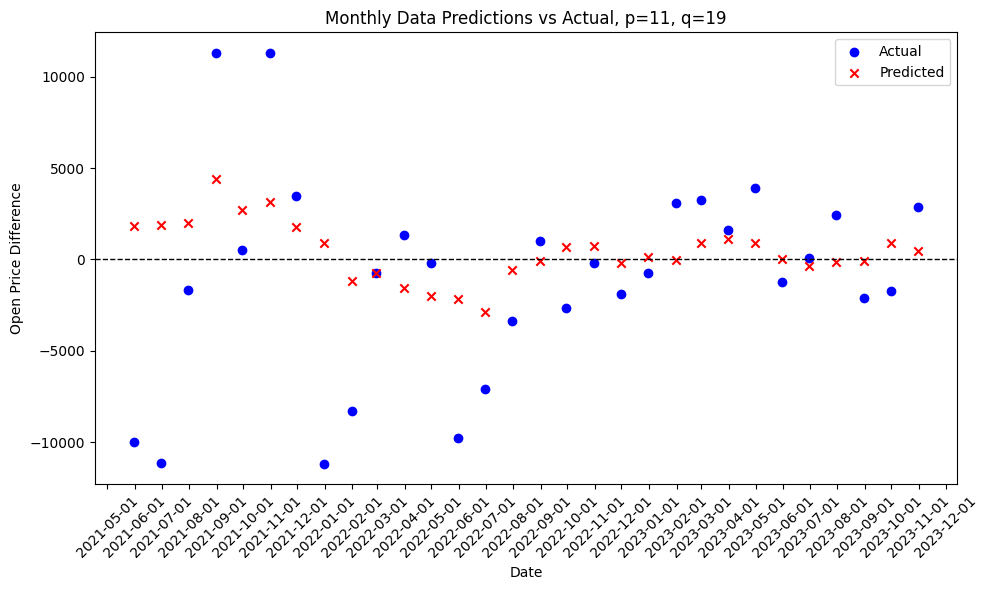

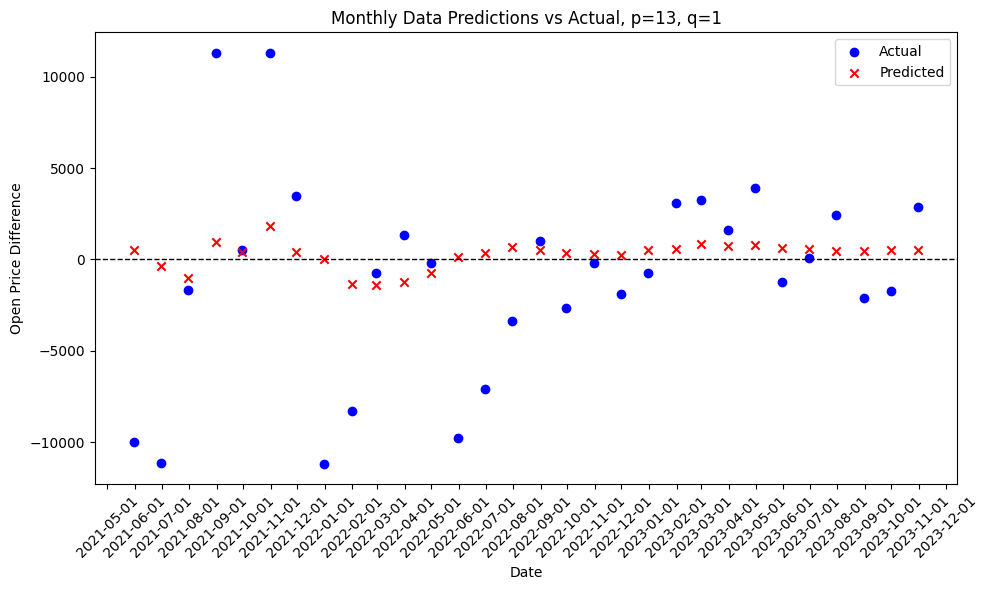

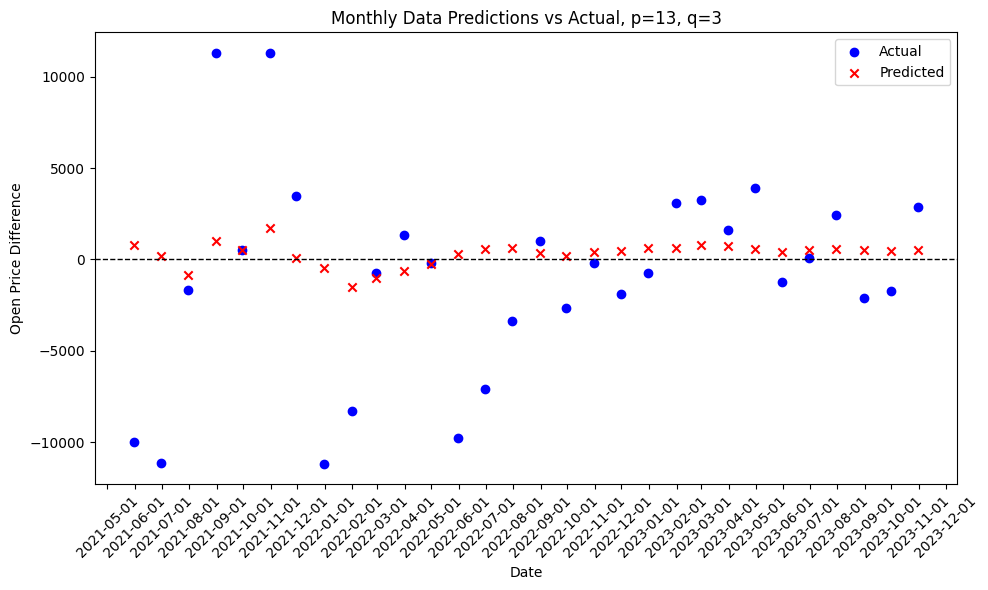

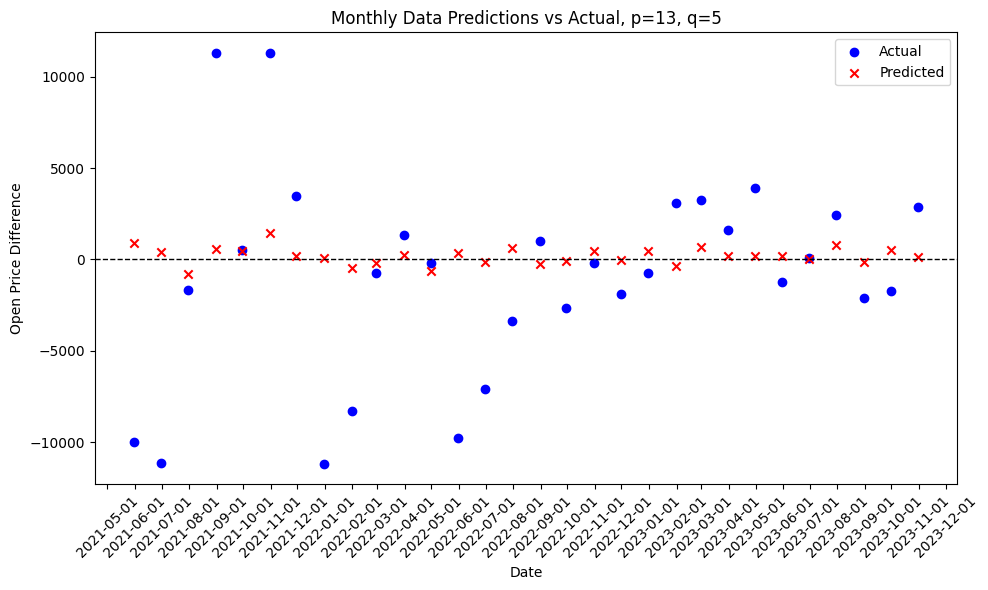

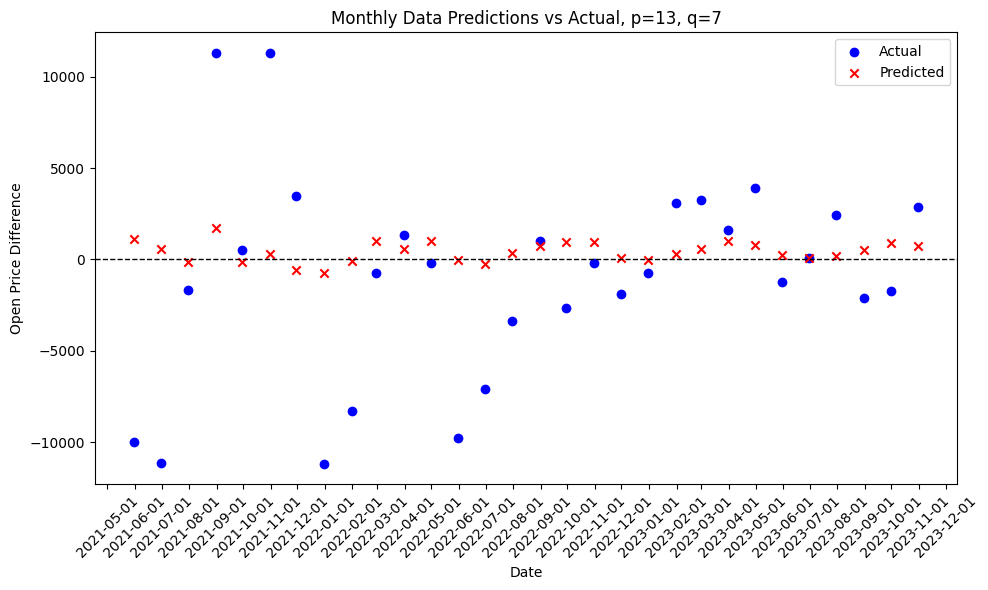

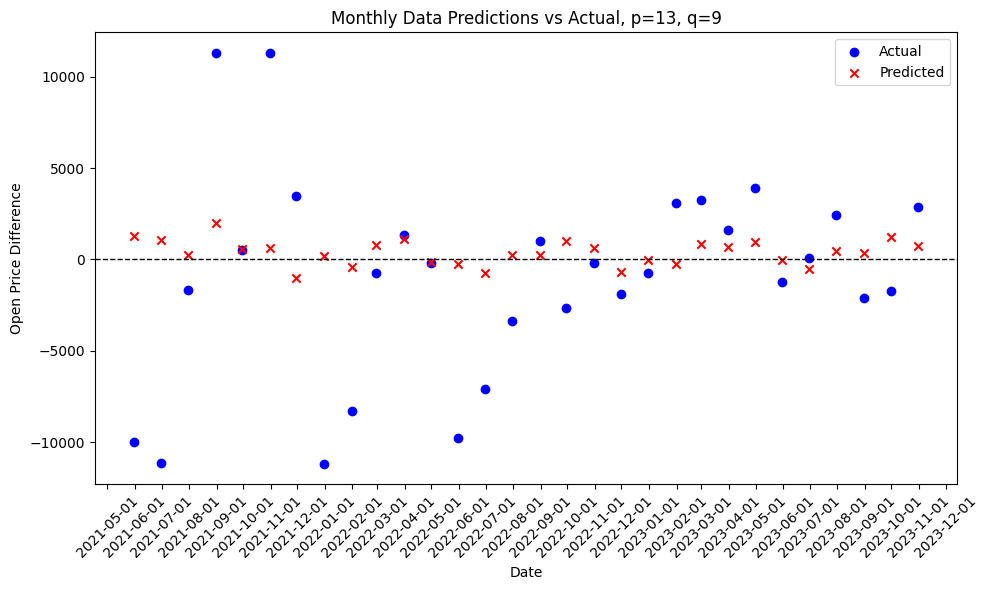

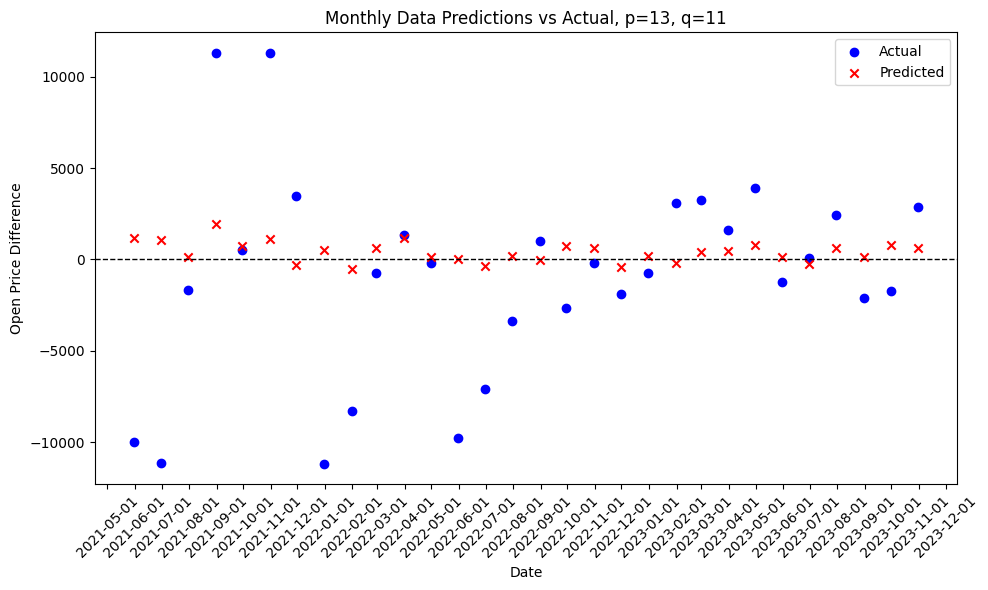

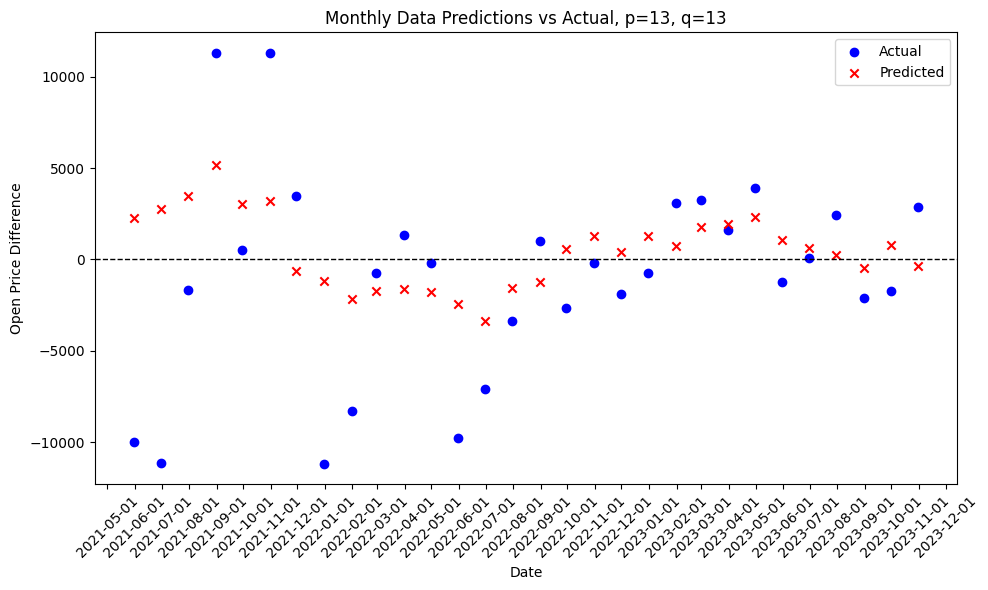

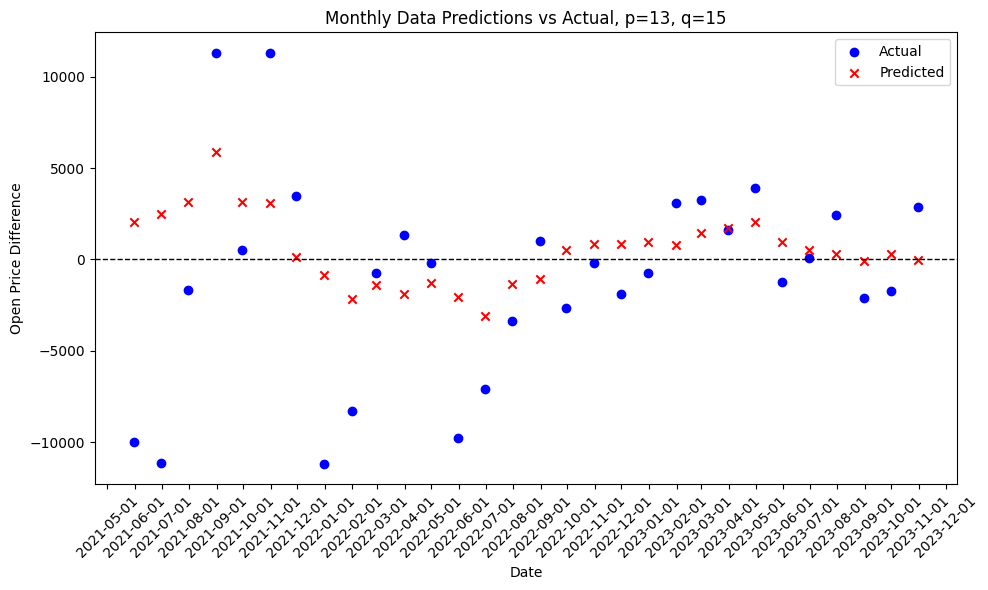

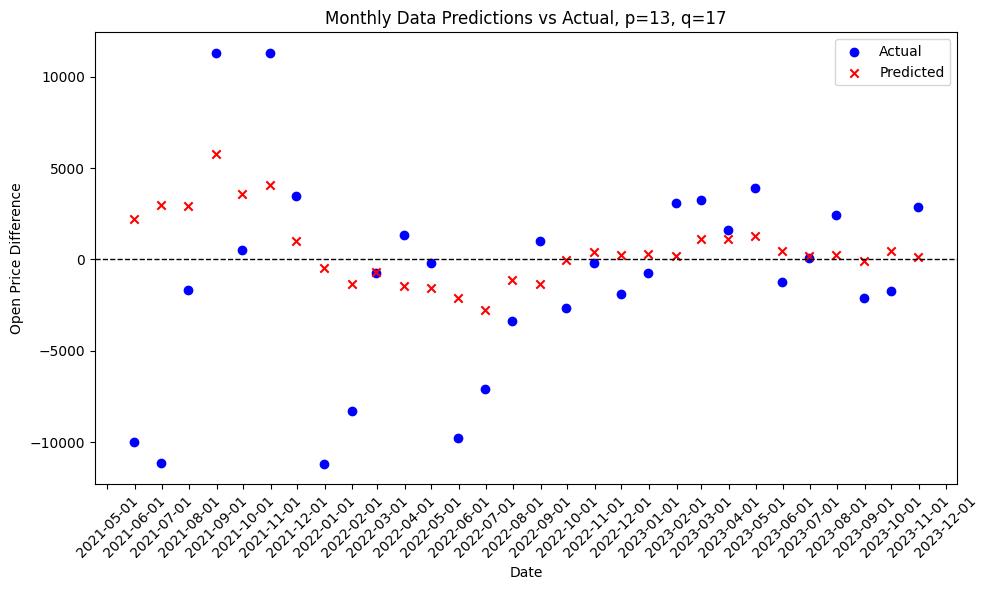

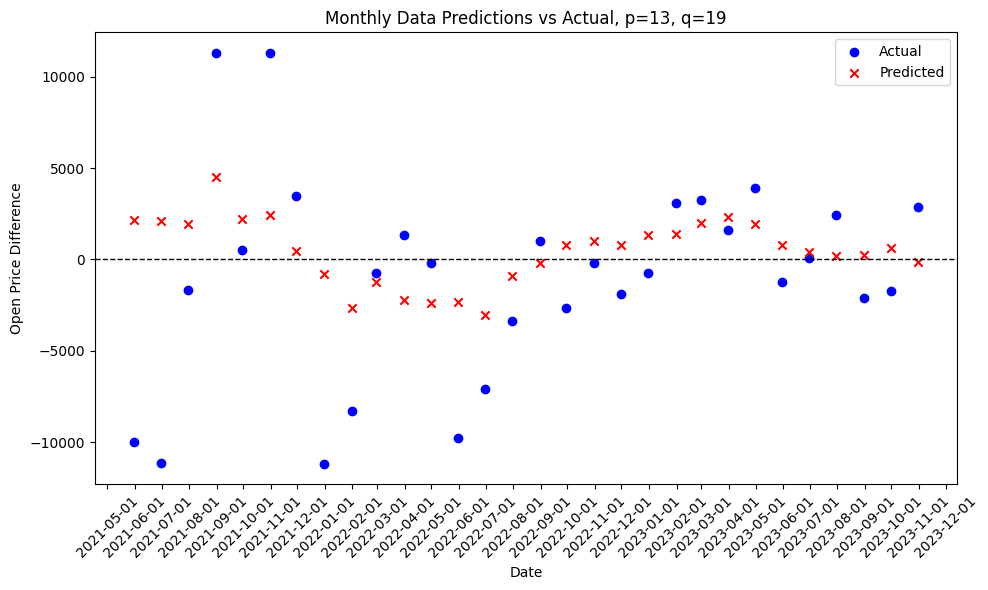

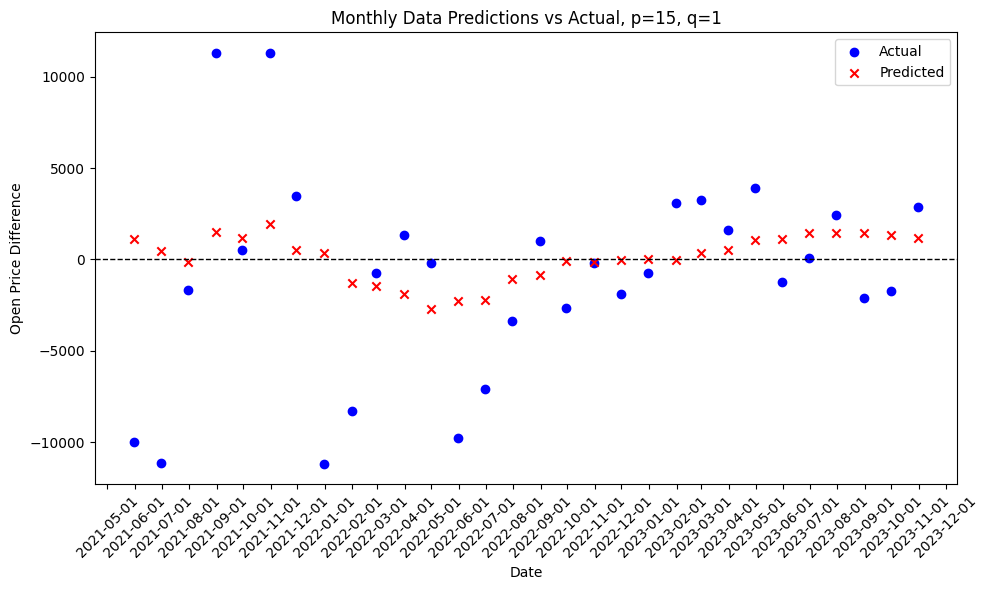

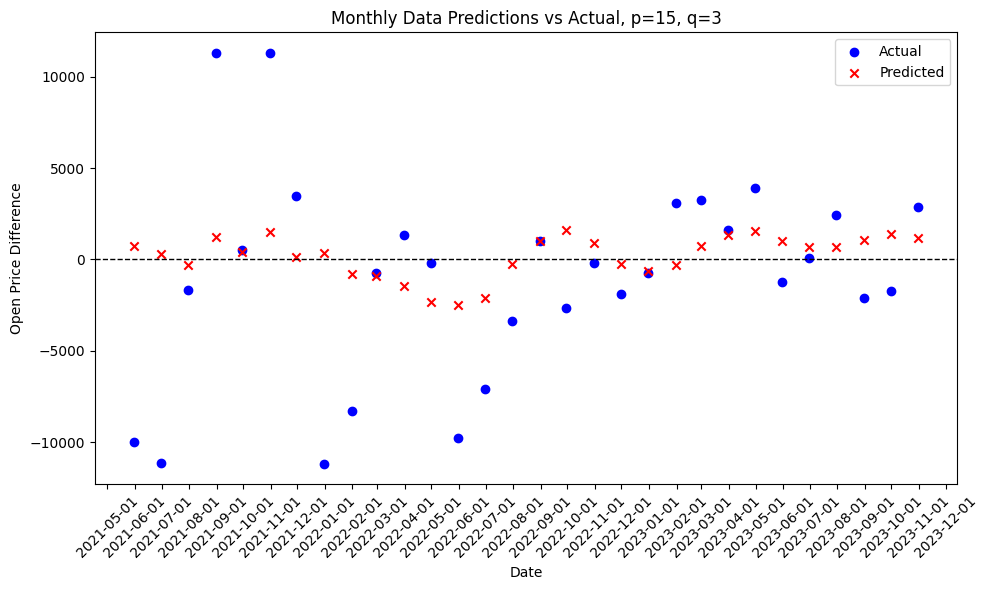

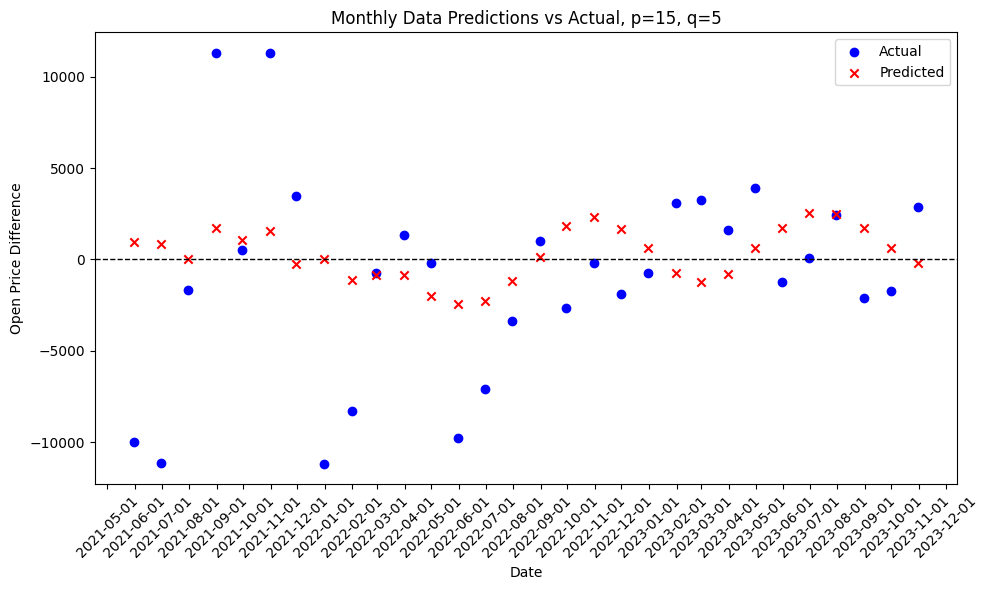

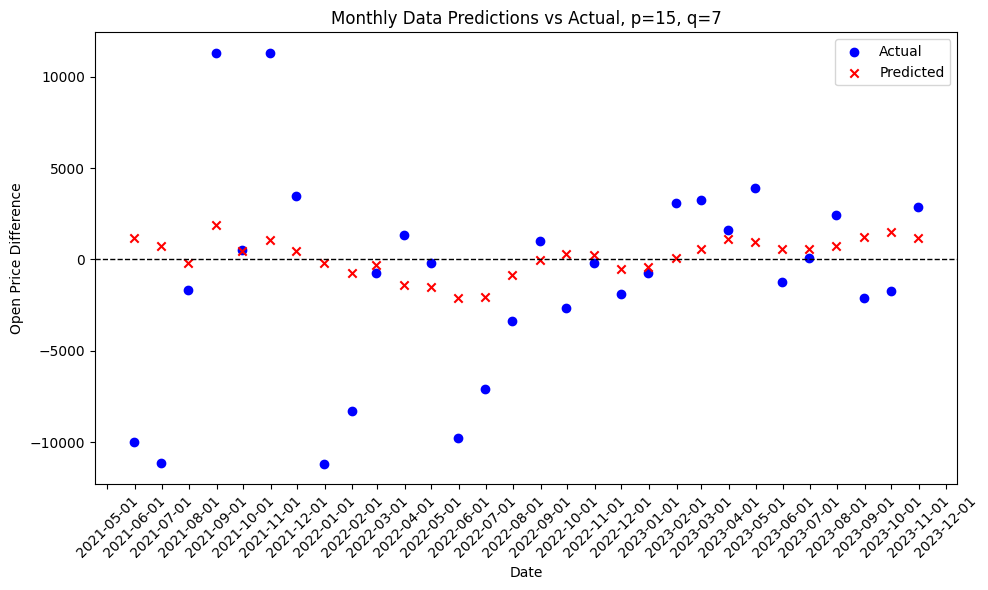

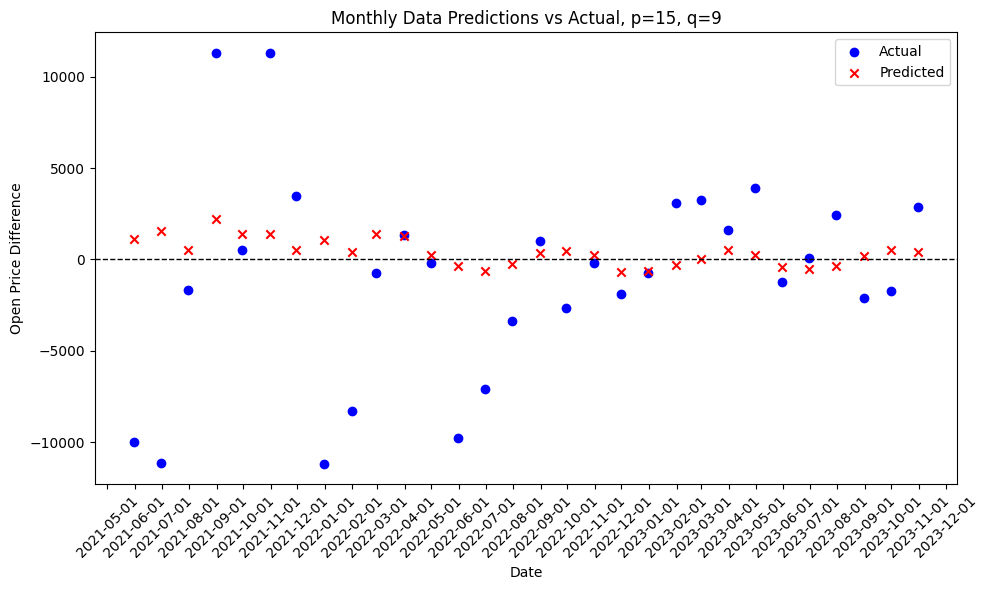

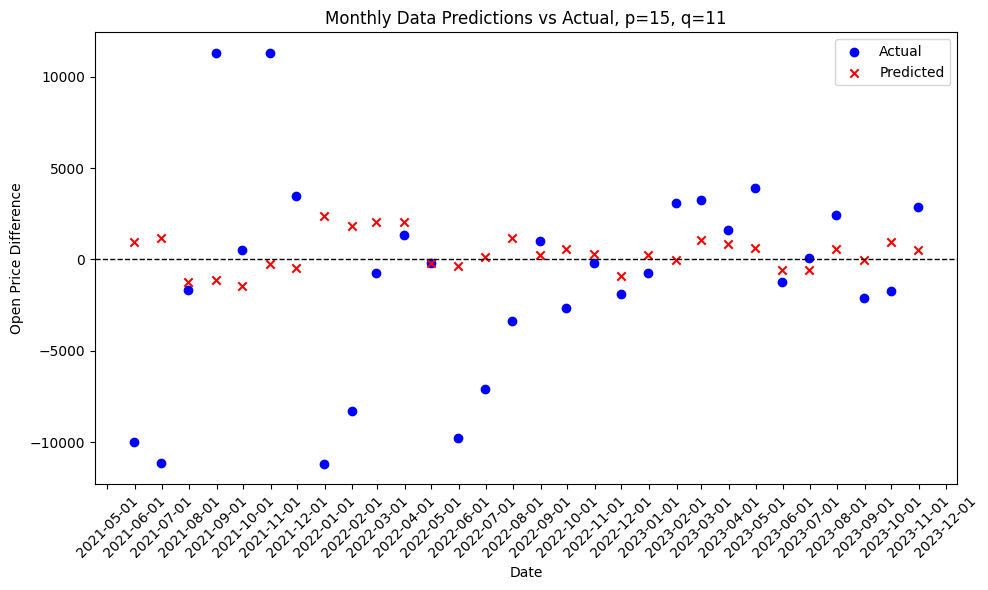

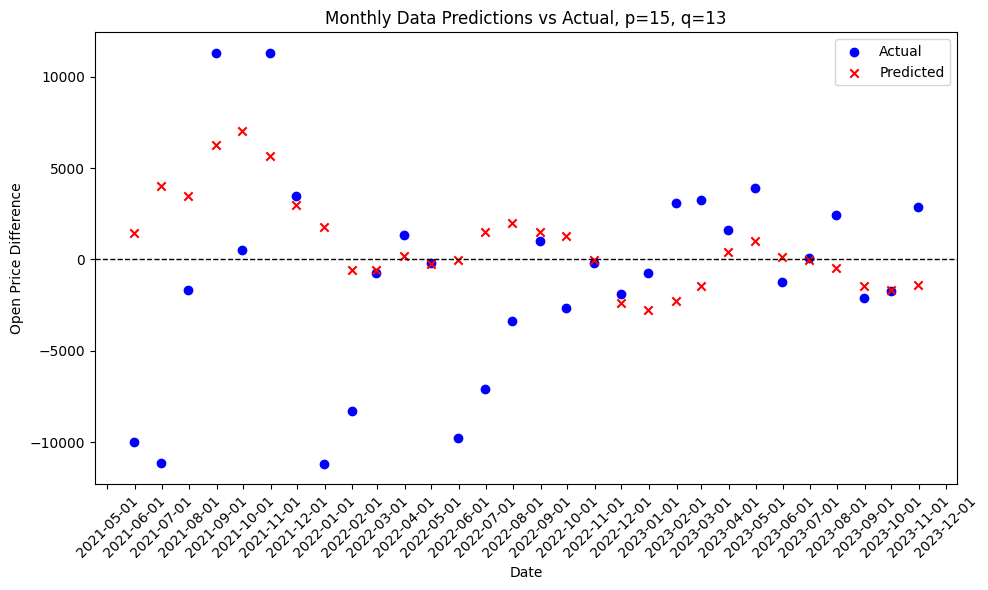

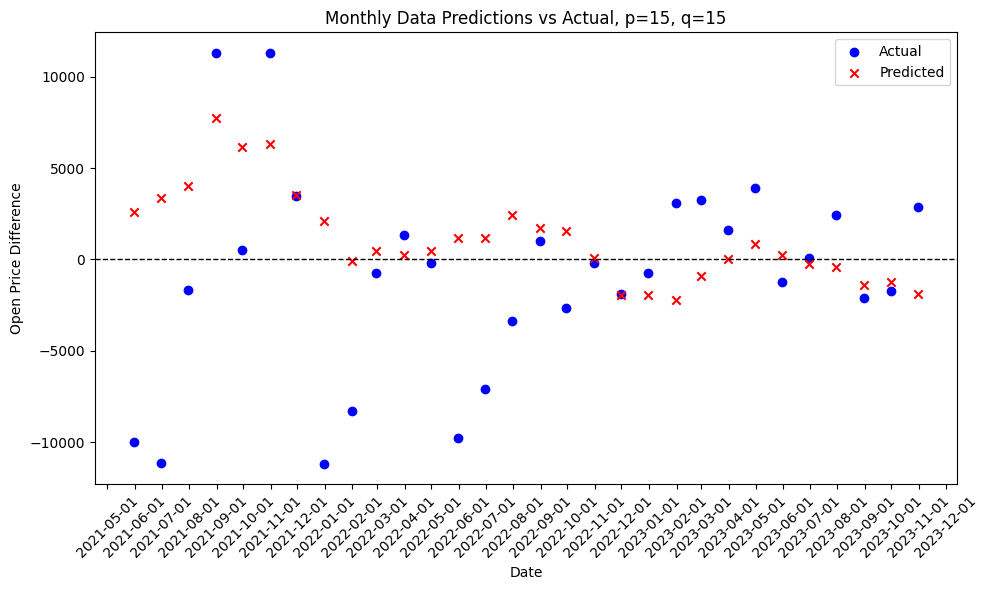

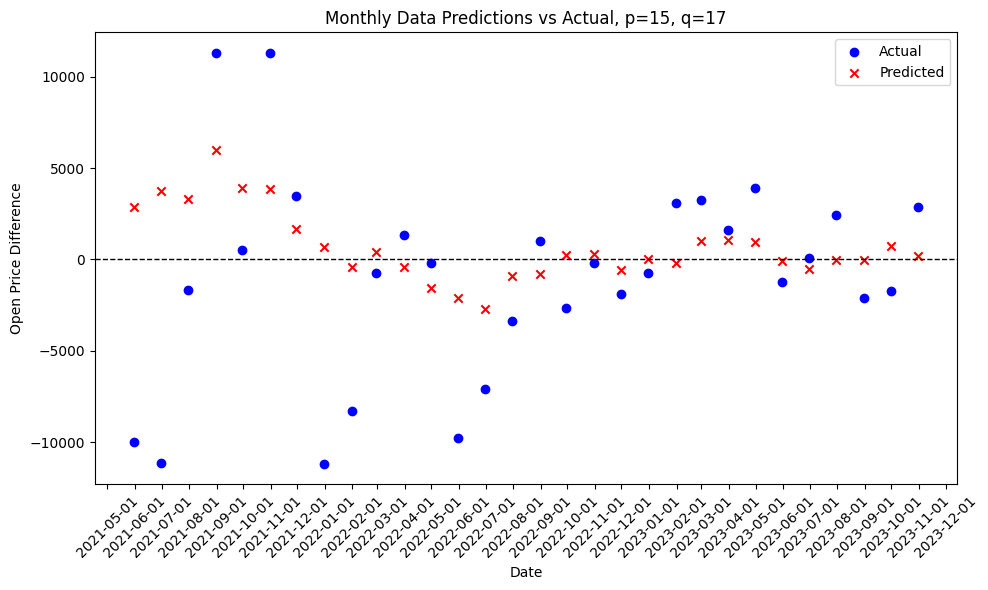

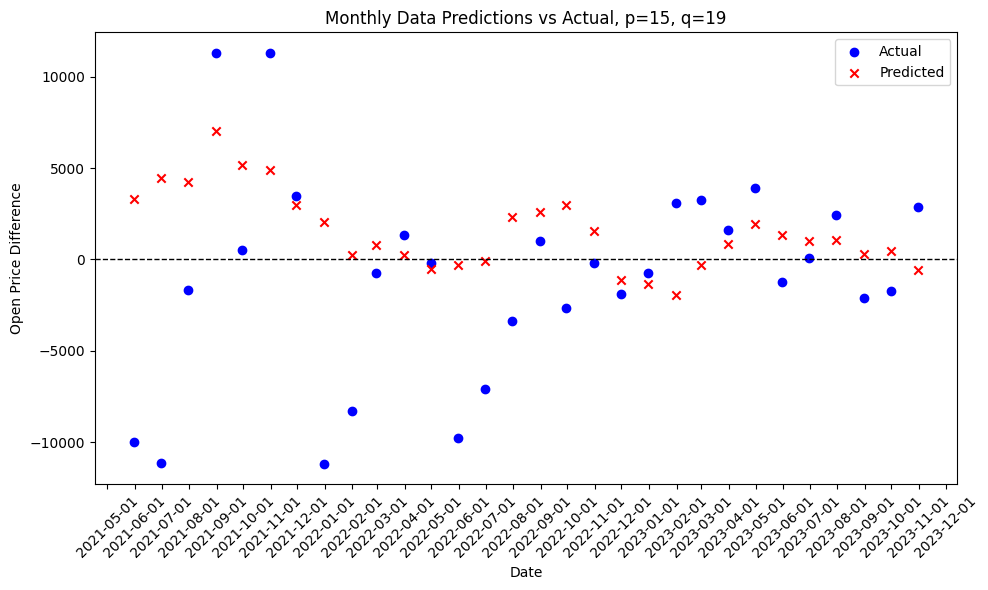

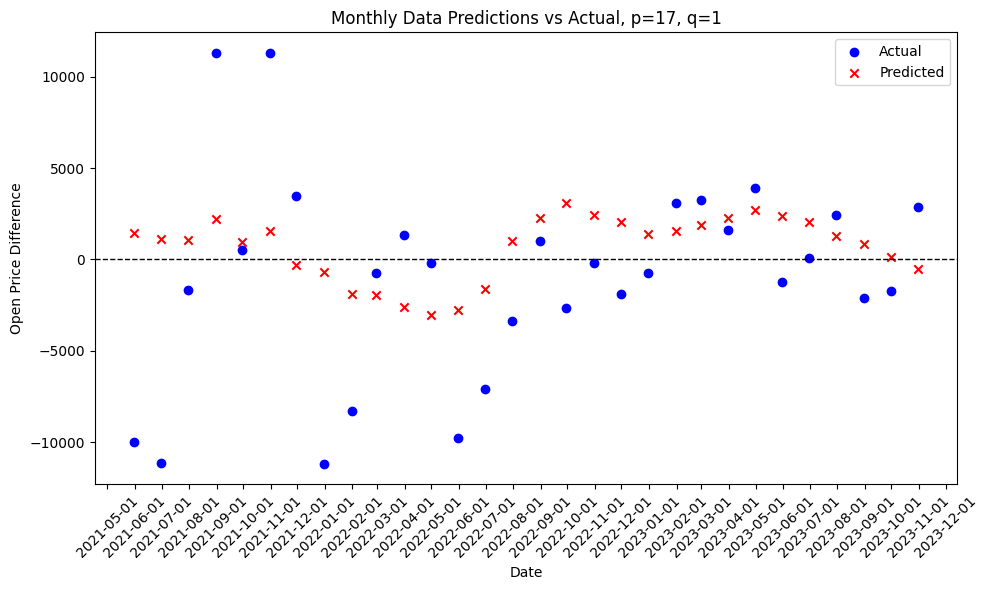

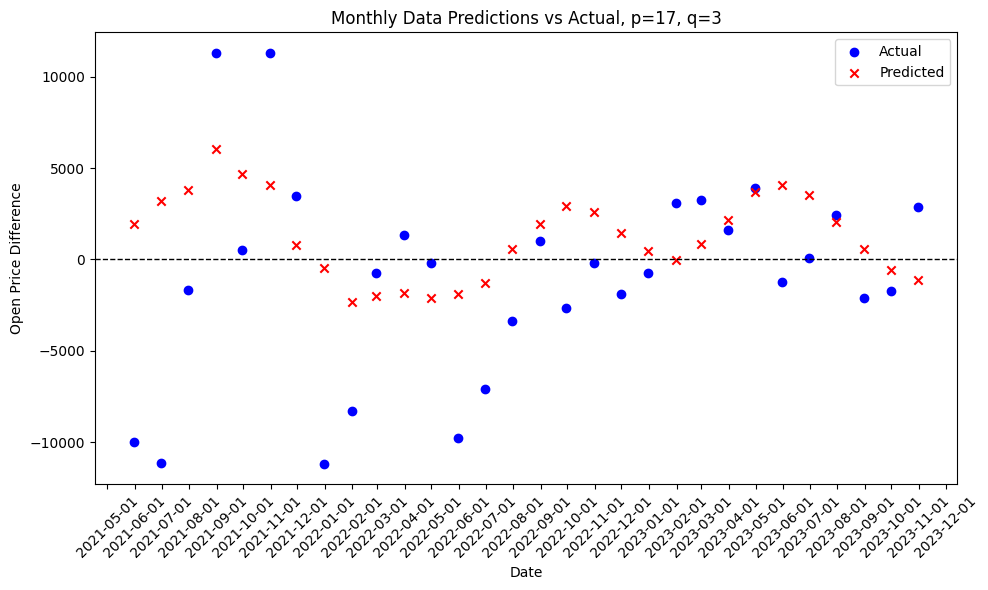

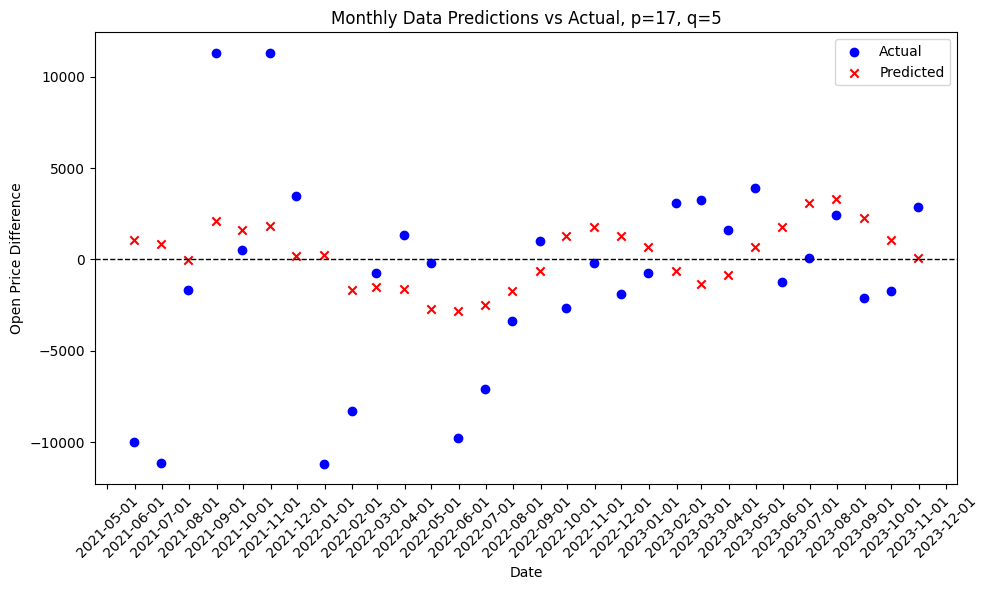

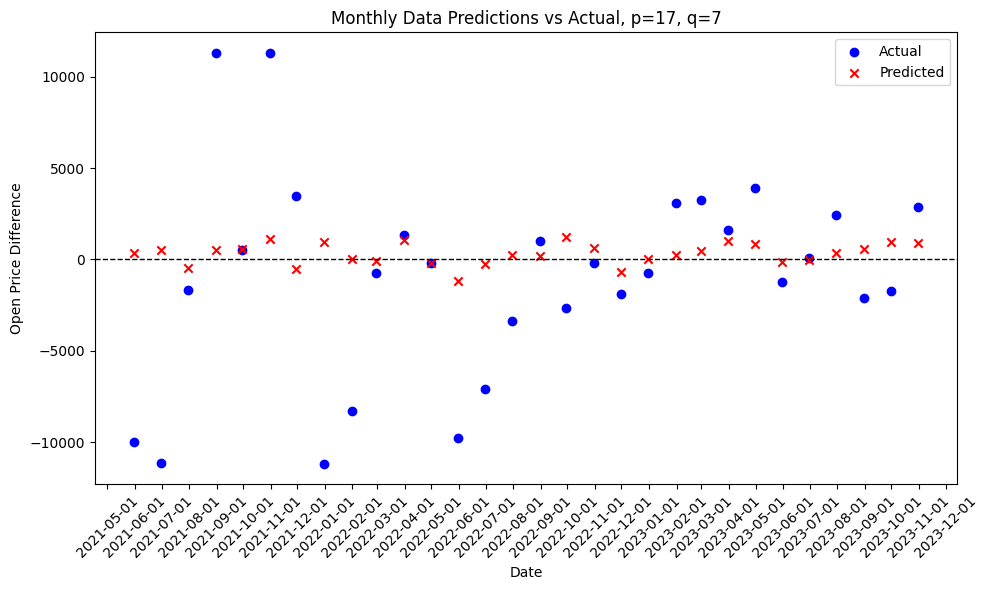

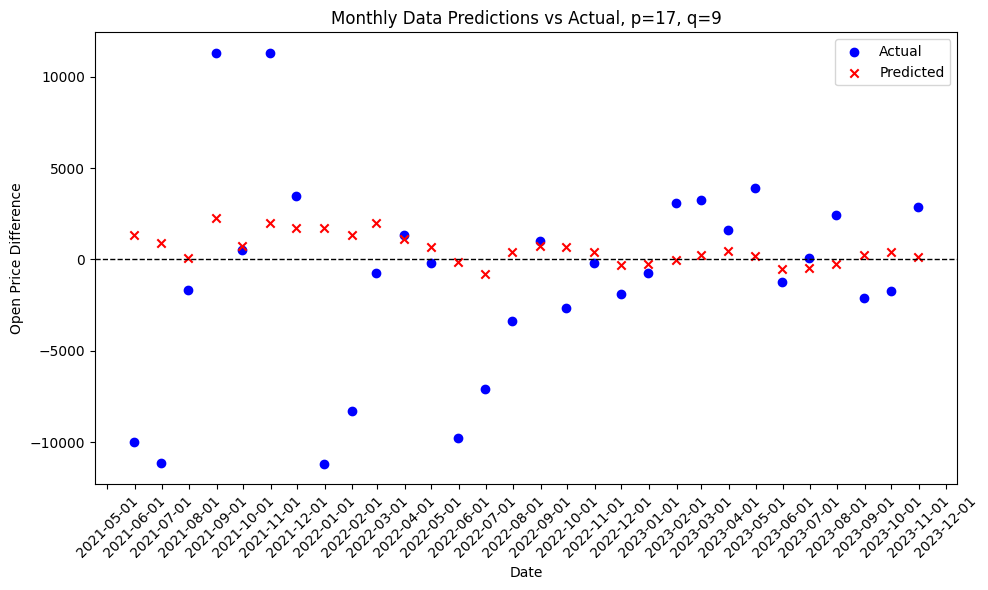

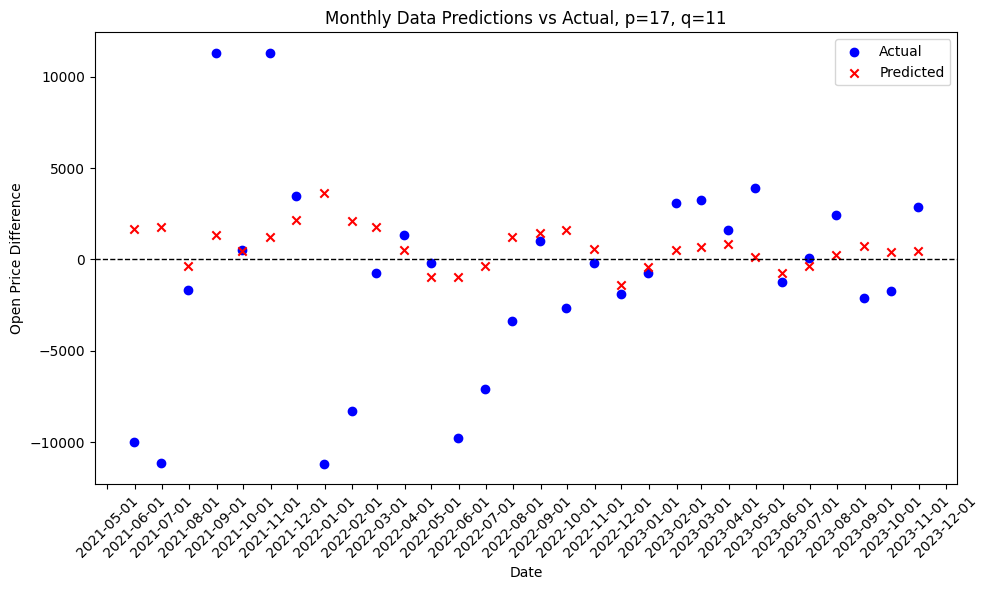

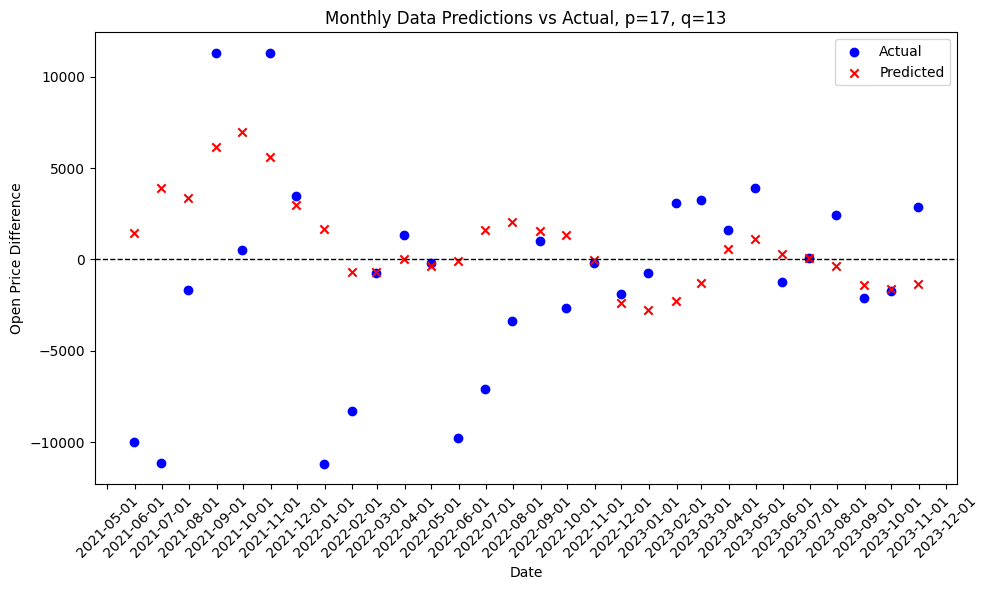

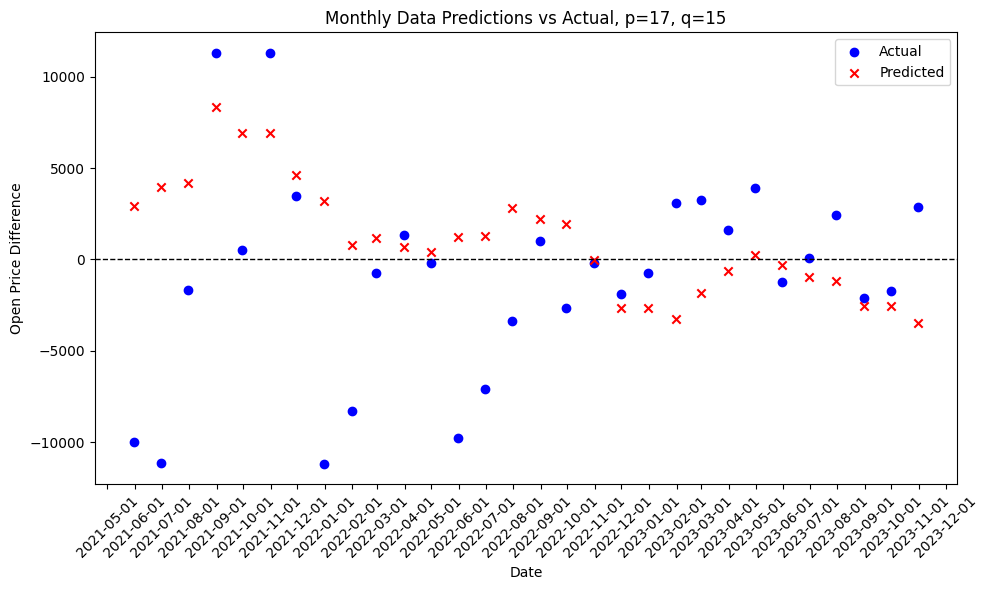

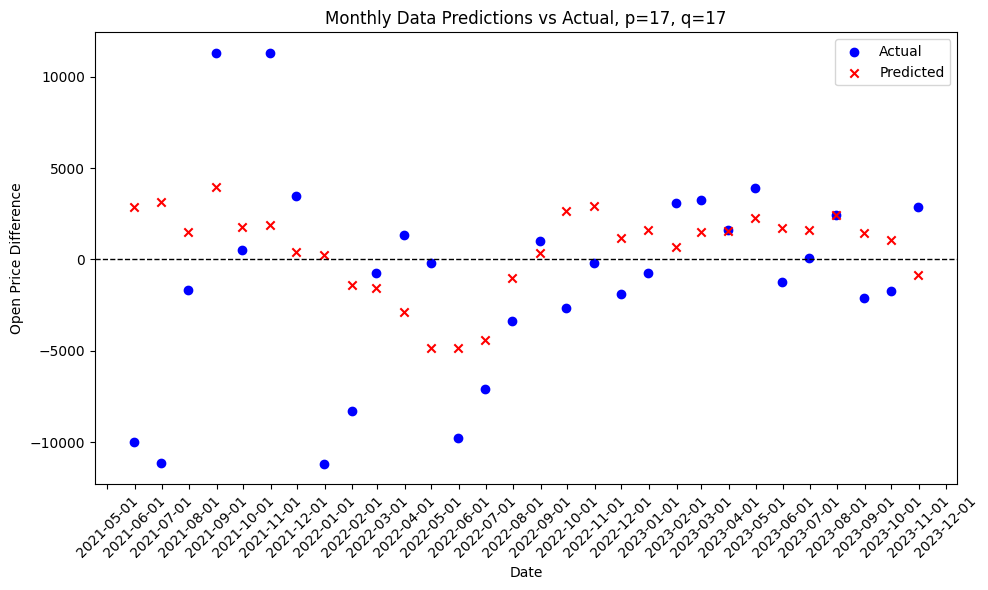

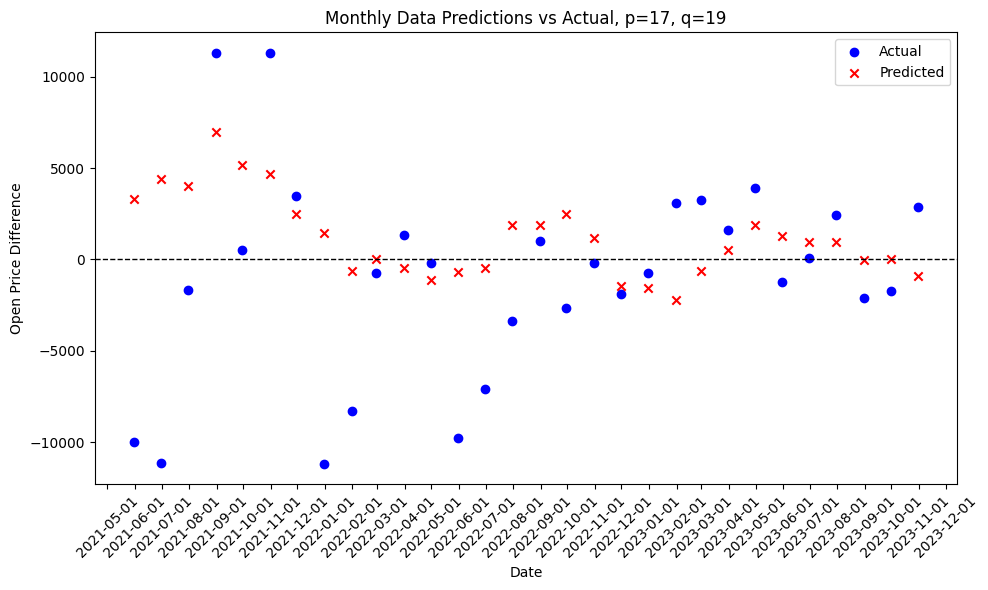

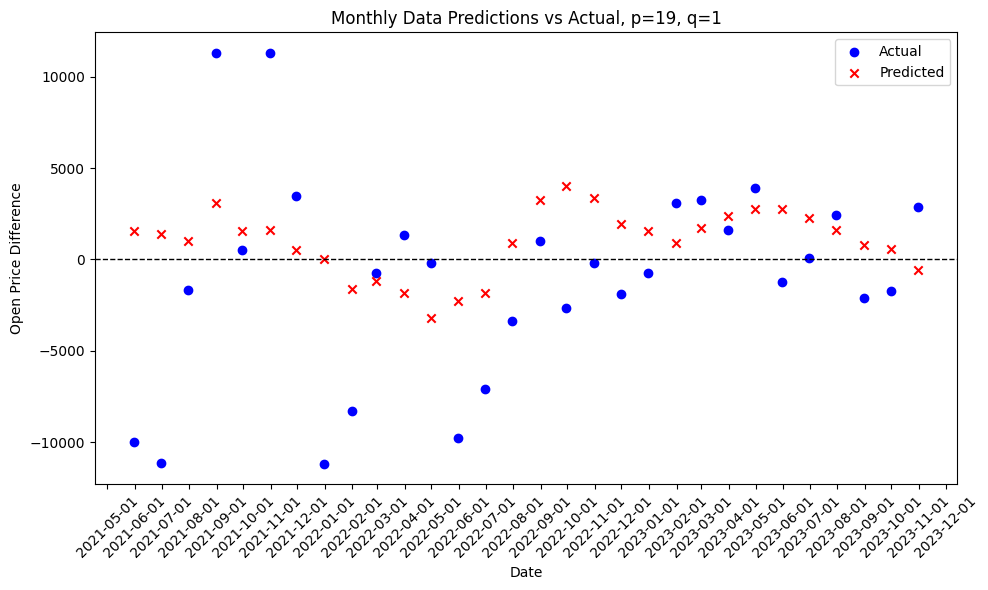

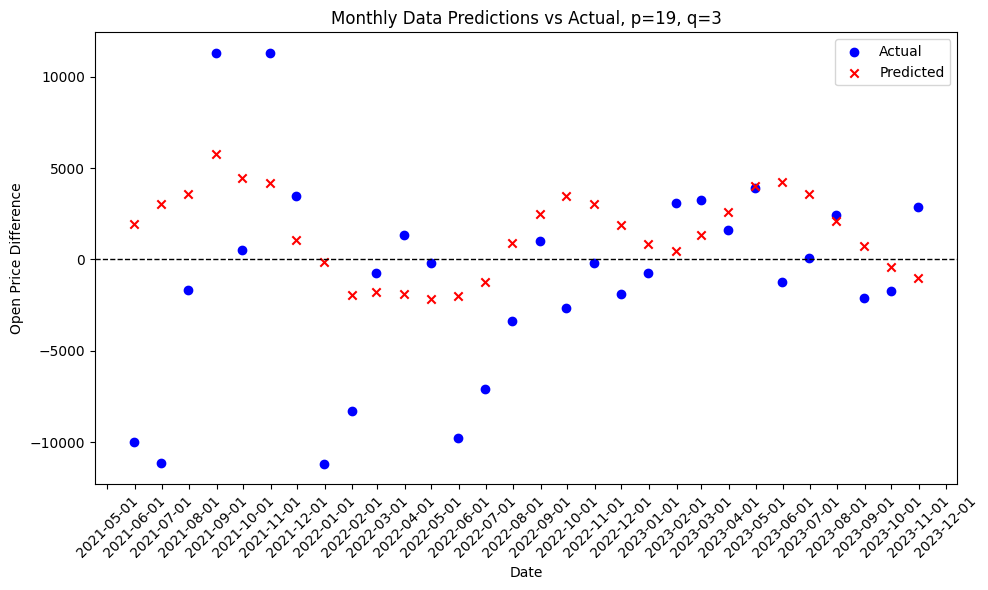

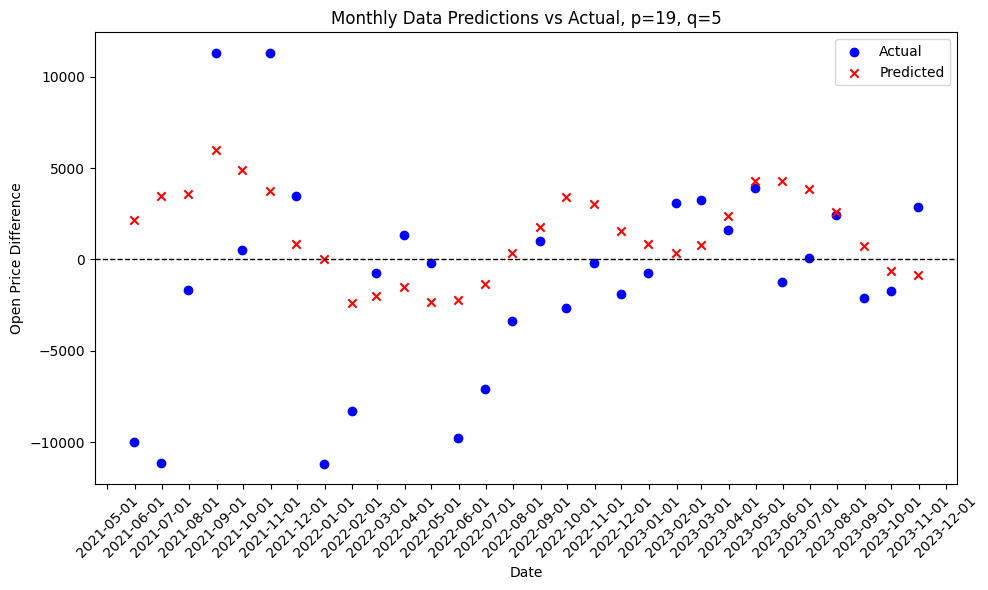

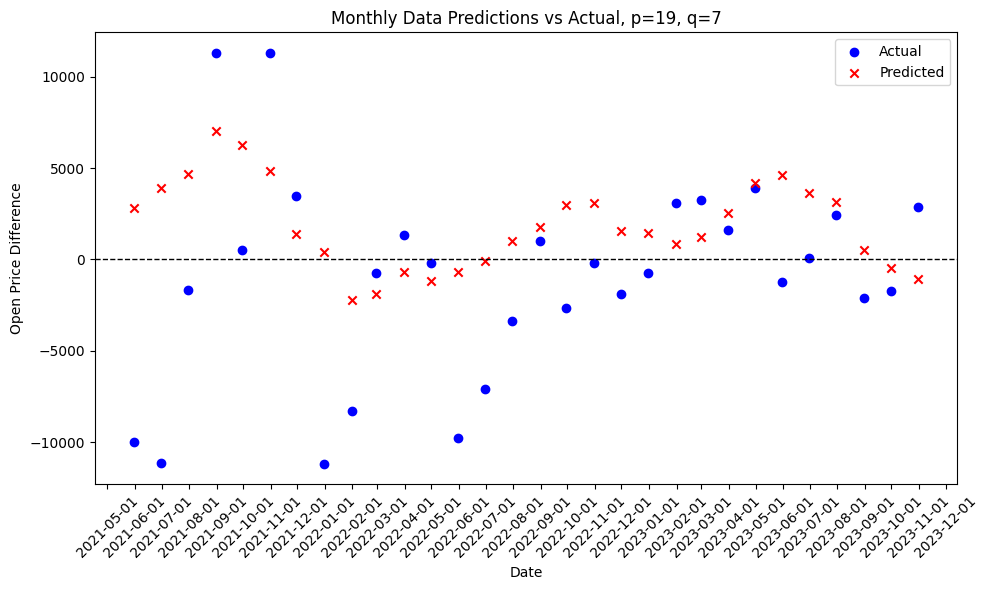

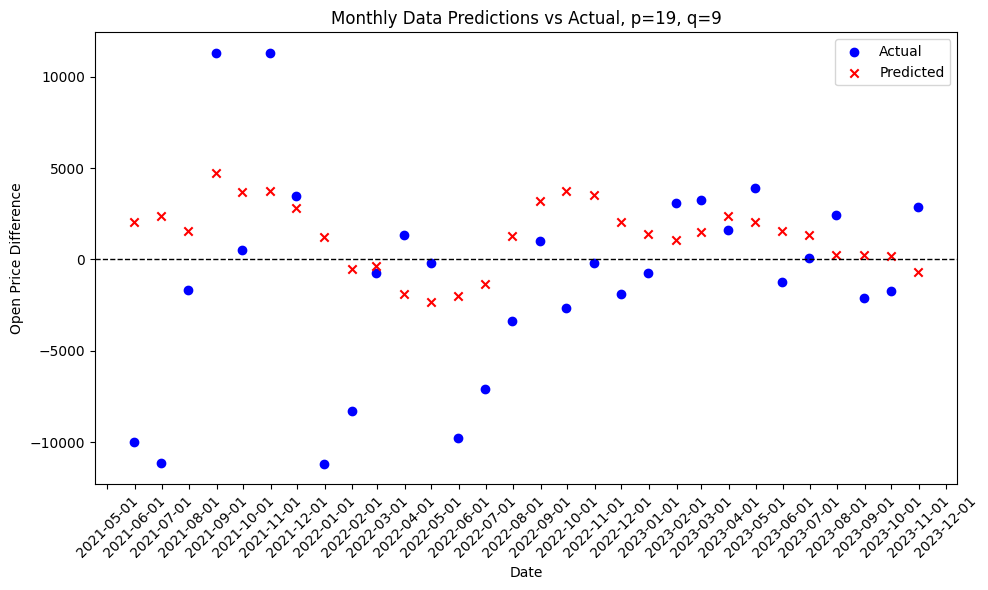

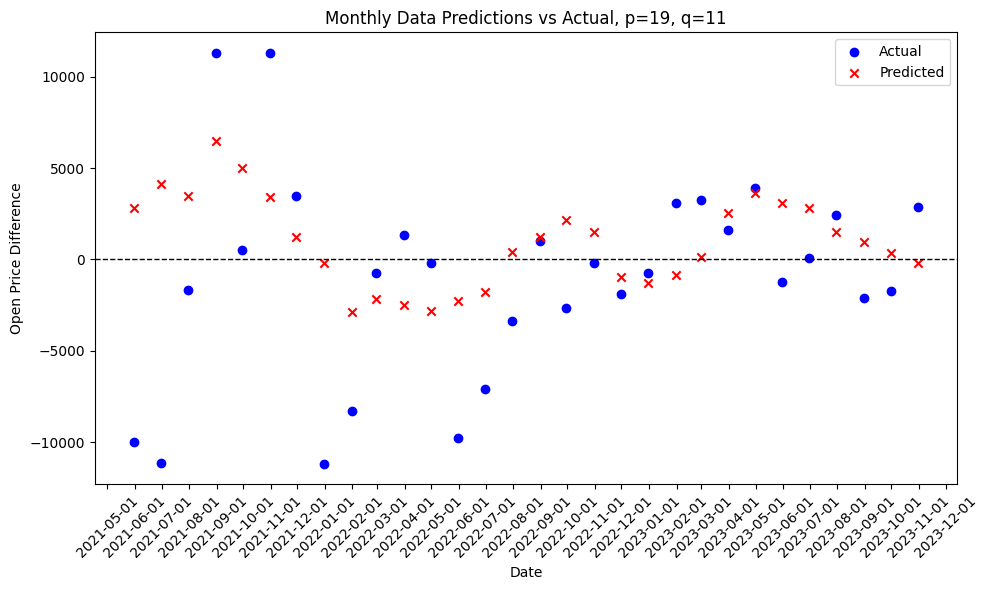

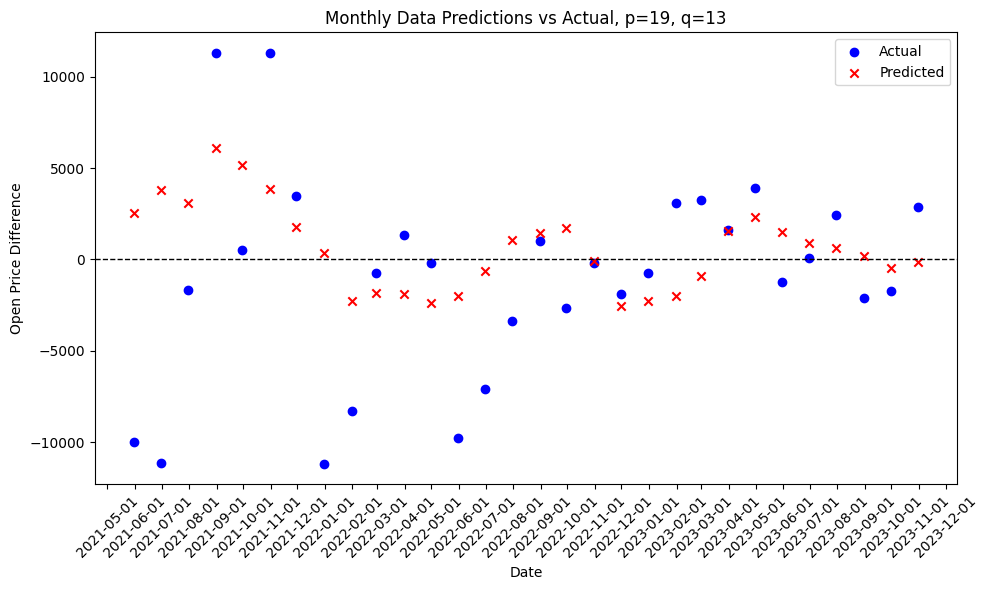

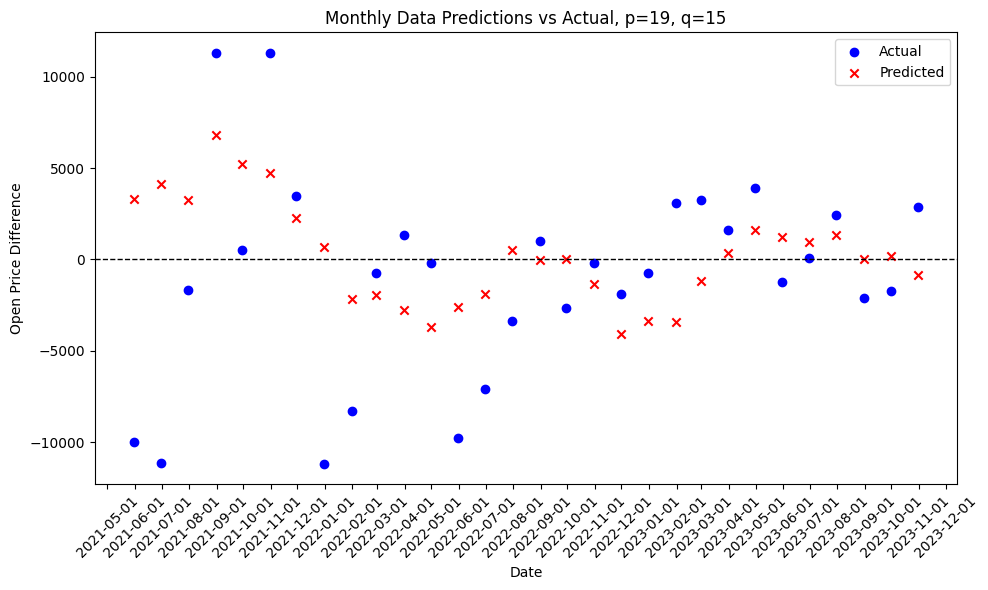

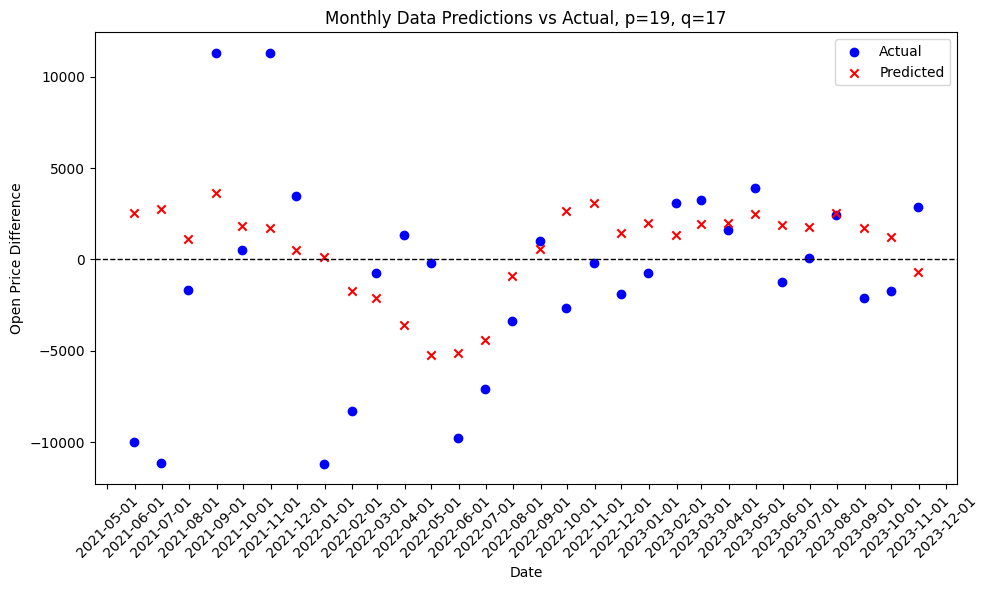

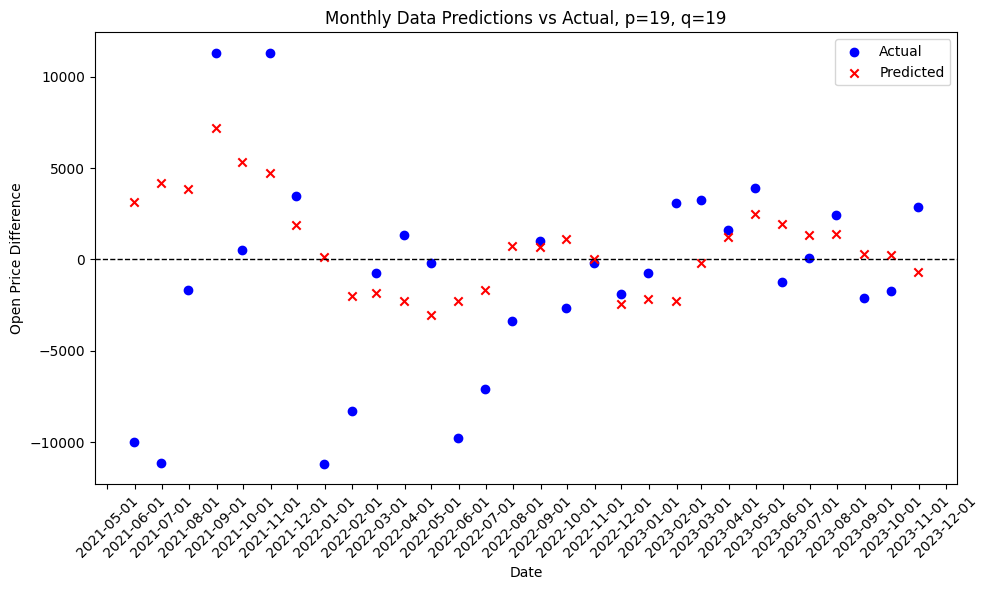

Model Estimation Results:
     p   q          MAE           MSE         RMSE          AIC          BIC  \
0    1   1  4183.080502  3.337614e+07  5777.208606  2110.665633  2124.603092   
1    1   3  4050.993810  3.139773e+07  5603.367429  2112.417030  2131.929472   
2    1   5  4058.158404  3.129483e+07  5594.178510  2111.813592  2136.901017   
3    1   7  4085.370929  3.154899e+07  5616.849188  2120.600362  2151.262771   
4    1   9  4117.370846  3.259356e+07  5709.076629  2122.965612  2159.203004   
5    1  11  3960.806190  3.002619e+07  5479.615409  2122.856561  2164.668938   
6    1  13  3845.491087  2.685188e+07  5181.879919  2137.740897  2185.128256   
7    1  15  3865.646057  2.702581e+07  5198.635174  2147.119647  2200.081990   
8    1  17  4036.179889  2.994089e+07  5471.827283  2159.294516  2217.831843   
9    1  19  3952.371838  2.814969e+07  5305.628007  2176.323355  2240.435665   
10   3   1  4157.379504  3.292420e+07  5737.961400  2109.860499  2129.372941   
11   3   3  40

p   q          MAE           MSE         RMSE          AIC          BIC  \
0    1   1  4183.080502  3.337614e+07  5777.208606  2110.665633  2124.603092   
1    1   3  4050.993810  3.139773e+07  5603.367429  2112.417030  2131.929472   
2    1   5  4058.158404  3.129483e+07  5594.178510  2111.813592  2136.901017   
3    1   7  4085.370929  3.154899e+07  5616.849188  2120.600362  2151.262771   
4    1   9  4117.370846  3.259356e+07  5709.076629  2122.965612  2159.203004   
5    1  11  3960.806190  3.002619e+07  5479.615409  2122.856561  2164.668938   
6    1  13  3845.491087  2.685188e+07  5181.879919  2137.740897  2185.128256   
7    1  15  3865.646057  2.702581e+07  5198.635174  2147.119647  2200.081990   
8    1  17  4036.179889  2.994089e+07  5471.827283  2159.294516  2217.831843   
9    1  19  3952.371838  2.814969e+07  5305.628007  2176.323355  2240.435665   
10   3   1  4157.379504  3.292420e+07  5737.961400  2109.860499  2129.372941   
11   3   3  4065.923880  3.143499e+07  5606.691742  2113.361727  2138.449153   
12   3   5  3932.737667  2.953844e+07  5434.927534  2118.234904  2148.897313   
13   3   7  4038.524905  3.082723e+07  5552.227040  2123.073967  2159.311359   
14   3   9  3977.405450  2.936316e+07  5418.778799  2123.283412  2165.095788   
15   3  11  4189.775840  3.175740e+07  5635.370791  2127.334862  2174.722222   
16   3  13  4250.531892  3.147675e+07  5610.414618  2137.357931  2190.320274   
17   3  15  3862.274984  2.595380e+07  5094.487385  2149.030216  2207.567543   
18   3  17  4159.575834  2.912347e+07  5396.616195  2160.939469  2225.051780   
19   3  19  3775.617092  2.510700e+07  5010.688930  2176.803559  2246.490853   
20   5   1  4101.738826  3.194056e+07  5651.598051  2112.370018  2137.457444   
21   5   3  4004.131242  2.984540e+07  5463.094755  2114.712473  2145.374882   
22   5   5  3972.393831  2.893167e+07  5378.816470  2120.381027  2156.618419   
23   5   7  4117.868839  3.105291e+07  5572.513799  2123.702262  2165.514638   
24   5   9  3937.283612  2.924635e+07  5407.989904  2127.511083  2174.898442   
25   5  11  4370.656694  3.492687e+07  5909.896108  2131.169349  2184.131692   
26   5  13  4211.296839  3.160243e+07  5621.604291  2140.587516  2199.124842   
27   5  15  3953.589718  2.906130e+07  5390.853795  2144.052956  2208.165266   
28   5  17  3865.014020  2.732277e+07  5227.118876  2151.878013  2221.565306   
29   5  19  3931.711128  2.808476e+07  5299.505608  2165.017538  2240.279815   
30   7   1  3981.876205  3.048908e+07  5521.691500  2115.480194  2146.142603   
31   7   3  3955.810645  2.891518e+07  5377.284071  2118.903932  2155.141325   
32   7   5  4637.845920  3.808144e+07  6171.016244  2125.030990  2166.843366   
33   7   7  4026.077589  2.934301e+07  5416.919044  2127.060123  2174.447483   
34   7   9  3934.077013  2.922228e+07  5405.763766  2130.911964  2183.874307   
35   7  11  3957.547290  2.925606e+07  5408.887316  2135.672863  2194.210190   
36   7  13  3919.638833  2.655854e+07  5153.497967  2141.292828  2205.405139   
37   7  15  3899.608190  2.928929e+07  5411.957985  2147.509416  2217.196710   
38   7  17  4077.724811  2.945218e+07  5426.986594  2154.377265  2229.639542   
39   7  19  4166.490069  2.975289e+07  5454.620965  2167.633261  2248.470521   
40   9   1  4025.325405  3.122780e+07  5588.184210  2120.988762  2157.226154   
41   9   3  4018.851667  3.115965e+07  5582.082613  2122.629891  2164.442267   
42   9   5  3984.983990  2.647675e+07  5145.556176  2124.409247  2171.796606   
43   9   7  3954.464770  2.988696e+07  5466.897097  2130.569034  2183.531377   
44   9   9  3970.607144  3.014093e+07  5490.075138  2132.502269  2191.039596   
45   9  11  4056.347216  3.103959e+07  5571.318502  2137.191235  2201.303545   
46   9  13  3886.504981  2.665111e+07  5162.471762  2140.914073  2210.601367   
47   9  15  3888.932427  2.755755e+07  5249.528605  2150.634025  2225.896302   
48   9  17  4306.020691  3.190302e+07  5648.275495  2156.750690  2237.587950   
49   

In [32]:
print("Monthly Data Model Estimation:")
monthly_data, weekly_data, daily_data = get_data('2016-01-01', '9999-01-01')
model_estimation(monthly_data, range(1, 20, 2), range(1, 20, 2), title='Monthly Data', ratio=0.8)
# model_estimation(monthly_data, range(15, 35, 3), range(15, 35, 3), title='Monthly Data')
# model_estimation(monthly_data, [19], [15])
# model_estimation(monthly_data, [8], [6])
results_df

In [33]:
# print("Monthly Data Model Estimation:")
# monthly_data, weekly_data, daily_data = get_data('2000-01-01', '2016-01-01')
# model_estimation(monthly_data, range(1, 20, 2), range(1, 20, 2), title='Monthly Data', ratio=0.77)
# # model_estimation(monthly_data, range(15, 35, 3), range(15, 35, 3), title='Monthly Data')
# # model_estimation(monthly_data, [19], [15])
# # model_estimation(monthly_data, [8], [6])
# results_df

In [34]:
# print("Weekly Data Model Estimation:")
# model_estimation(weekly_data, range(0, 51), range(0, 51))
# model_estimation(weekly_data, range(1, 60, 5), range(1, 60, 5), title='Weekly Data')
# model_estimation(weekly_data, [6], [1])

In [35]:
# print("Daily Data Model Estimation:")
# # model_estimation(daily_data, range(0, 361), range(0, 361))
# model_estimation(daily_data, [1], [1])

Distribution Plot:


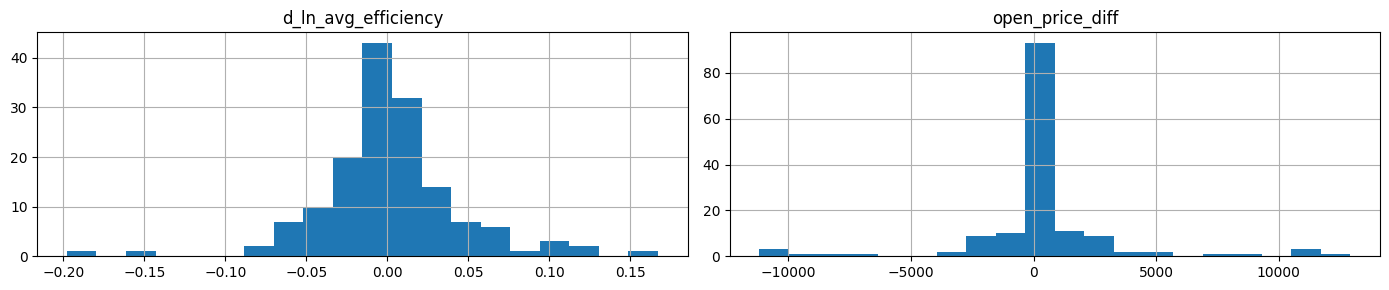

Summary Statistics:
ACF and PACF Plots for d_ln_avg_efficiency:


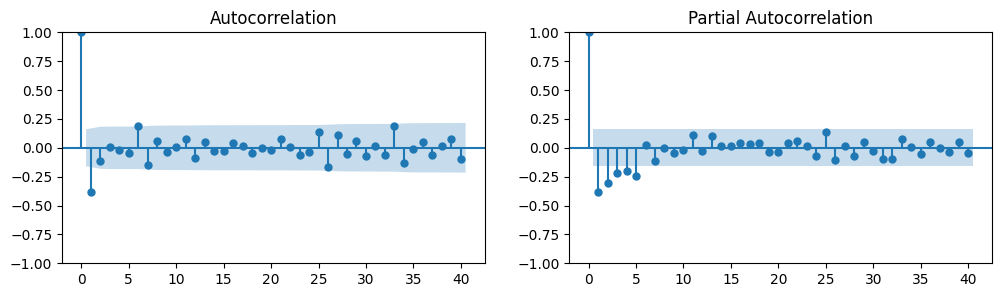

count        mean          std           min        25%  \
d_ln_avg_efficiency  150.0    0.002143     0.043361     -0.197860  -0.016406   
open_price_diff      150.0  194.384023  3140.265957 -11177.666621 -82.301651   

                          50%         75%           max  skewness  kurtosis  
d_ln_avg_efficiency  0.000845    0.017456      0.167210 -0.201346  4.904535  
open_price_diff      2.817531  267.025553  12924.081989  0.291467  7.268140

In [39]:

# Function to perform exploratory data analysis
def exploratory_analysis(df):
    # Select only numeric columns for distribution, skewness, and kurtosis
    # numeric_df = df.select_dtypes(include=[np.number])
    numeric_df = df[['d_ln_avg_efficiency', 'open_price_diff']]
    
    num_cols = len(numeric_df.columns)
    num_rows = (num_cols + 1) // 2  # Ensure enough rows to accommodate all columns
    print("Distribution Plot:")
    numeric_df.hist(bins=20, figsize=(14, num_rows * 3), layout=(num_rows, 2))
    plt.tight_layout()
    plt.show()

    print("Summary Statistics:")
    summary = numeric_df.describe().T
    summary['std'] = numeric_df.std()
    summary['skewness'] = numeric_df.skew()
    summary['kurtosis'] = numeric_df.kurtosis()
    # print(summary)

    for col in ['d_ln_avg_efficiency', 'd_ln_max_efficiency']:
        if col in numeric_df.columns:
            print(f"ACF and PACF Plots for {col}:")
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            sm.graphics.tsa.plot_acf(numeric_df[col].dropna(), lags=40, ax=axes[0])
            sm.graphics.tsa.plot_pacf(numeric_df[col].dropna(), lags=40, ax=axes[1])
            plt.show()

    return summary

# Perform exploratory data analysis
# print("Monthly Data Analysis:")
summary = exploratory_analysis(monthly_data)

# print("Weekly Data Analysis:")
# exploratory_analysis(weekly_data)

# print("Daily Data Analysis:")
# exploratory_analysis(daily_data)
summary